### RPV analysis for District 1 (POC only)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None)

import numpy as np

import maup
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
maup.progress.enabled = True

from pyei.goodmans_er import GoodmansER, GoodmansERBayes
from pyei.two_by_two import TwoByTwoEI
from pyei.r_by_c import RowByColumnEI

import arviz as az

from tqdm import tqdm

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Precinct file:

In [2]:
D1_precincts_df = pd.read_csv("./Data/District precinct files/D1 precincts/D1_precincts_with_data.csv")

In [3]:
D1_precincts_df

Unnamed: 0 Precinct  District  TOTPOP20    VAP20  HVAP20  AAPIVAP20  \
0            0    M4406         1      40.0     38.0     5.0        5.0   
1            1    M4407         1     138.0    120.0    16.0        3.0   
2            2    M4508         1   13496.0  10988.0  1523.0     1410.0   
3            3    M4509         1    1810.0   1479.0   109.0      272.0   
4            4    M4605         1    5626.0   4508.0   677.0      884.0   
5            5    M4606         1    6790.0   5480.0   519.0     1768.0   
6            6    M4607         1    9071.0   7120.0  1144.0     1290.0   
7            7    M4702         1    4848.0   4076.0   446.0      615.0   
8            8    M4703         1   11130.0   8856.0  1339.0     1321.0   
9            9    M4704         1    9456.0   7276.0  1161.0     1088.0   
10          10    M4705         1    6425.0   5210.0   488.0      735.0   
11          11    M4706         1    5410.0   4408.0   462.0      683.0   
12          12    M4707         1   12665.0  10403.0  1289.0     1235.0   
13          13    M4708         1   13989.0  10738.0  1745.0     1841.0   
14          14    M4709         1    2393.0   1847.0   226.0      312.0   
15          15    M4710         1    3140.0   2443.0   335.0      374.0   
16          16    M4801         1    1623.0   1281.0   154.0      326.0   
17          17    M4802         1   12237.0   9512.0  1264.0     1766.0   
18          18    M4803         1    9269.0   6904.0   984.0     1416.0   
19          19    M4804         1   12714.0   9629.0  1203.0     1926.0   
20          20    M4805         1    1131.0    768.0   228.0      135.0   
21          21    M4806         1   13217.0  10216.0  1323.0     1871.0   
22          22    M4809         1       0.0      0.0     0.0        0.0   
23          23    M4910         1     891.0    684.0   121.0       65.0   
24          24    M5001         1     373.0    289.0    69.0       30.0   
25          25    M5003         1    1178.0    856.0   181.0      144.0   
26          26     C112         1       0.0      0.0     0.0        0.0   
27          27     C113         1     103.0     84.0     4.0        8.0   
28          28     C114         1     335.0    267.0    26.0       43.0   

    BVAP20  AMINVAP20  WVAP20        DVAP22      HDVAP22   AAPIDVAP22  \
0      4.0        5.0    19.0     35.849090     3.542857     4.597701   
1      9.0        3.0    89.0    119.265475    16.000000     3.000000   
2   1468.0      276.0  6311.0  10045.601363   898.222627  1232.384442   
3    218.0       21.0   859.0   1341.243900    52.861235   197.917681   
4    214.0      118.0  2615.0   3897.387376   408.538462   658.002243   
5    421.0      114.0  2658.0   4774.509764   432.957178  1289.089261   
6    514.0      238.0  3934.0   6398.633539   920.145714   949.780049   
7    378.0       71.0  2566.0   3517.890714   210.879160   434.295751   
8   1040.0      192.0  4964.0   7907.613462   733.830700  1099.948658   
9    550.0      166.0  4311.0   6245.496257   660.308562   739.357989   
10   421.0      119.0  3447.0   4961.276926   466.207493   597.673229   
11   373.0       83.0  2807.0   4131.230388   332.820612   634.968370   
12  1141.0      287.0  6451.0   9016.827184   806.107438   936.690259   
13   860.0      262.0  6030.0   9217.299586  1174.691727  1445.252017   
14   134.0       29.0  1146.0   1623.546189   119.807229   252.220472   
15   325.0       48.0  1361.0   2209.063707   218.665758   335.106501   
16    69.0       29.0   703.0   1118.203693   132.119079   208.907568   
17   635.0      258.0  5589.0   8234.091615   914.723349  1159.163163   
18   616.0      146.0  3742.0   5853.479115   574.169703   973.450002   
19   647.0      186.0  5667.0   8357.195227   708.503033  1393.926385   
20    67.0       23.0   315.0    594.861880   123.225434    76.099760   
21   665.0      228.0  6129.0   8914.940787   728.484398  1357.222767   
22     0.0        0.0     0.0      0.000000     0.000000     0.000000   
2

### Precinct C112 has no population and no votes, and Precinct M4809 has no population and 8 votes (which is even worse!), so let's remove these two precincts.

In [4]:
D1_precincts_df = D1_precincts_df.drop([22, 26]).reset_index(drop=True)

In [5]:
D1_precincts_df 

Unnamed: 0 Precinct  District  TOTPOP20    VAP20  HVAP20  AAPIVAP20  \
0            0    M4406         1      40.0     38.0     5.0        5.0   
1            1    M4407         1     138.0    120.0    16.0        3.0   
2            2    M4508         1   13496.0  10988.0  1523.0     1410.0   
3            3    M4509         1    1810.0   1479.0   109.0      272.0   
4            4    M4605         1    5626.0   4508.0   677.0      884.0   
5            5    M4606         1    6790.0   5480.0   519.0     1768.0   
6            6    M4607         1    9071.0   7120.0  1144.0     1290.0   
7            7    M4702         1    4848.0   4076.0   446.0      615.0   
8            8    M4703         1   11130.0   8856.0  1339.0     1321.0   
9            9    M4704         1    9456.0   7276.0  1161.0     1088.0   
10          10    M4705         1    6425.0   5210.0   488.0      735.0   
11          11    M4706         1    5410.0   4408.0   462.0      683.0   
12          12    M4707         1   12665.0  10403.0  1289.0     1235.0   
13          13    M4708         1   13989.0  10738.0  1745.0     1841.0   
14          14    M4709         1    2393.0   1847.0   226.0      312.0   
15          15    M4710         1    3140.0   2443.0   335.0      374.0   
16          16    M4801         1    1623.0   1281.0   154.0      326.0   
17          17    M4802         1   12237.0   9512.0  1264.0     1766.0   
18          18    M4803         1    9269.0   6904.0   984.0     1416.0   
19          19    M4804         1   12714.0   9629.0  1203.0     1926.0   
20          20    M4805         1    1131.0    768.0   228.0      135.0   
21          21    M4806         1   13217.0  10216.0  1323.0     1871.0   
22          23    M4910         1     891.0    684.0   121.0       65.0   
23          24    M5001         1     373.0    289.0    69.0       30.0   
24          25    M5003         1    1178.0    856.0   181.0      144.0   
25          27     C113         1     103.0     84.0     4.0        8.0   
26          28     C114         1     335.0    267.0    26.0       43.0   

    BVAP20  AMINVAP20  WVAP20        DVAP22      HDVAP22   AAPIDVAP22  \
0      4.0        5.0    19.0     35.849090     3.542857     4.597701   
1      9.0        3.0    89.0    119.265475    16.000000     3.000000   
2   1468.0      276.0  6311.0  10045.601363   898.222627  1232.384442   
3    218.0       21.0   859.0   1341.243900    52.861235   197.917681   
4    214.0      118.0  2615.0   3897.387376   408.538462   658.002243   
5    421.0      114.0  2658.0   4774.509764   432.957178  1289.089261   
6    514.0      238.0  3934.0   6398.633539   920.145714   949.780049   
7    378.0       71.0  2566.0   3517.890714   210.879160   434.295751   
8   1040.0      192.0  4964.0   7907.613462   733.830700  1099.948658   
9    550.0      166.0  4311.0   6245.496257   660.308562   739.357989   
10   421.0      119.0  3447.0   4961.276926   466.207493   597.673229   
11   373.0       83.0  2807.0   4131.230388   332.820612   634.968370   
12  1141.0      287.0  6451.0   9016.827184   806.107438   936.690259   
13   860.0      262.0  6030.0   9217.299586  1174.691727  1445.252017   
14   134.0       29.0  1146.0   1623.546189   119.807229   252.220472   
15   325.0       48.0  1361.0   2209.063707   218.665758   335.106501   
16    69.0       29.0   703.0   1118.203693   132.119079   208.907568   
17   635.0      258.0  5589.0   8234.091615   914.723349  1159.163163   
18   616.0      146.0  3742.0   5853.479115   574.169703   973.450002   
19   647.0      186.0  5667.0   8357.195227   708.503033  1393.926385   
20    67.0       23.0   315.0    594.861880   123.225434    76.099760   
21   665.0      228.0  6129.0   8914.940787   728.484398  1357.222767   
22   121.0       16.0   361.0    592.511800    59.888889    46.485656   
23    26.0        8.0   156.0    208.818662    25.178947    20.973451   
24    47.0       29.0   455.0    687.014030    82.284108   105.874343   
25   

### Let's start with DVAP demographics for the district.

In [6]:
D1_precincts_df[['DVAP22', 'HDVAP22', 'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22']].sum()

DVAP22        110336.609663
HDVAP22        10834.163691
AAPIDVAP22     16195.549597
BDVAP22         9937.059772
AMINDVAP22      2688.600027
WDVAP22        70681.236577
dtype: float64

In [7]:
[(col+" pct:", D1_precincts_df[col].sum()/D1_precincts_df['DVAP22'].sum()) for col in ['HDVAP22', 'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22']]

[('HDVAP22 pct:', 0.09819192128642946),
 ('AAPIDVAP22 pct:', 0.1467830998799974),
 ('BDVAP22 pct:', 0.09006131149200342),
 ('AMINDVAP22 pct:', 0.02436725249163504),
 ('WDVAP22 pct:', 0.6405964148499346)]

### Create percentage columns for each of these, as well as a percentage column for POCDVAP22:

In [8]:
D1_precincts_df['POCDVAP22'] = D1_precincts_df['DVAP22'] - D1_precincts_df['WDVAP22']

In [9]:
for col in ['HDVAP22', 'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22', 'POCDVAP22']:
    D1_precincts_df[col+' pct'] = D1_precincts_df[col]/D1_precincts_df['DVAP22']

### What are the ranges of these percentages over precincts like?

(array([0., 0., 0., 1., 1., 1., 0., 1., 5., 6., 4., 3., 2., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 <BarContainer object of 24 artists>)

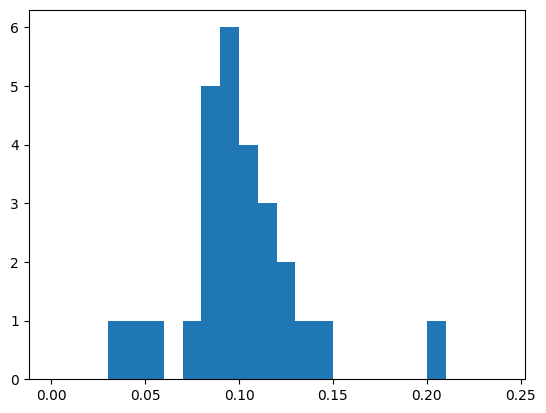

In [10]:
plt.hist(D1_precincts_df['HDVAP22 pct'], bins = [0.01*x for x in range(25)])

(array([0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 1., 5., 1., 4., 6., 3.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
 <BarContainer object of 29 artists>)

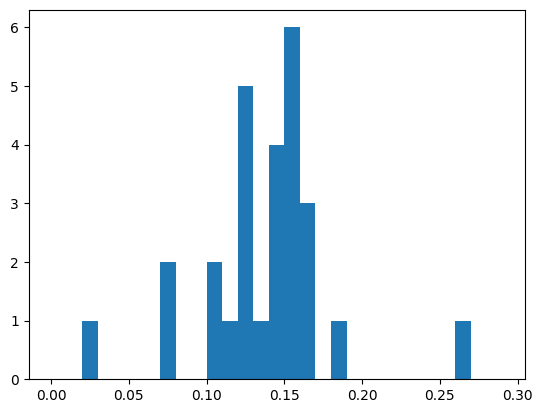

In [11]:
plt.hist(D1_precincts_df['AAPIDVAP22 pct'], bins = [0.01*x for x in range(30)])

(array([1., 1., 0., 0., 0., 1., 4., 4., 7., 1., 1., 1., 2., 1., 1., 1., 0.,
        0., 1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
 <BarContainer object of 19 artists>)

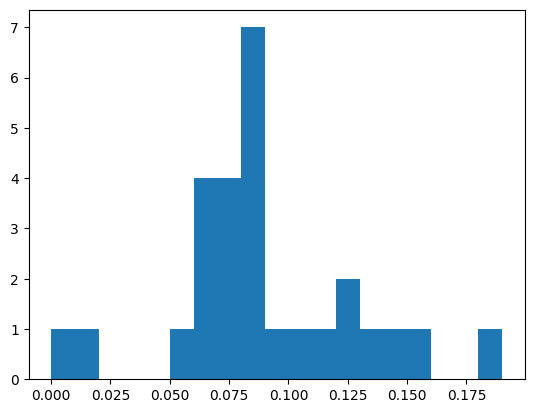

In [12]:
plt.hist(D1_precincts_df['BDVAP22 pct'], bins = [0.01*x for x in range(20)])

(array([ 0.,  7., 13.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14]),
 <BarContainer object of 14 artists>)

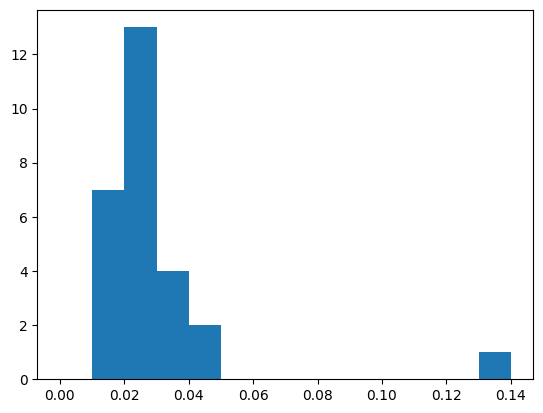

In [13]:
plt.hist(D1_precincts_df['AMINDVAP22 pct'], bins = [0.01*x for x in range(15)])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 2., 2., 2.,
        3., 0., 1., 3., 3., 2., 2., 0., 0., 0., 0., 0., 1., 2., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49]),
 <BarContainer object of 49 artists>)

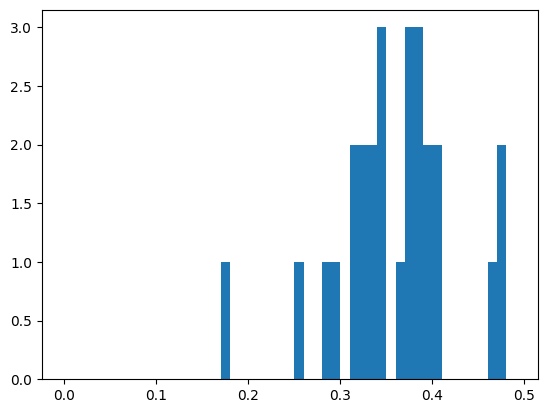

In [14]:
plt.hist(D1_precincts_df['POCDVAP22 pct'], bins = [0.01*x for x in range(50)])

### So there's some variation - much less for AMIN, which just has one very small outlier (5 people out of 36 = 14%).
### So let's skip AMIN and do the rest.

### Use the orignal condensed versions of the Rank 1 and Borda scores, because they're just not that difference from the viable-condensed versions.

### For election data, how did candidates' total district-wide scores compare for Rank 1 scores vs. Borda 654321 and Borda 521000 scores?

In [15]:
D1_candidates = [
    'Candace Avalos',
    'Jamie Dunphy',
    'Loretta Smith',
    'Noah Ernst',
    'Terrence Hayes',
    'Steph Routh',
    'Timur Ender'
]

D1_candidates_reversed = list(reversed(D1_candidates))

In [16]:
rank1_total = [D1_precincts_df[name + ' Condensed Rank 1'].sum() for name in D1_candidates_reversed]
borda654321_total = [D1_precincts_df[name + ' Condensed Borda 654321'].sum() for name in D1_candidates_reversed]
borda521000_total = [D1_precincts_df[name + ' Condensed Borda 521000'].sum() for name in D1_candidates_reversed]

rank1_pct = [x/sum(rank1_total) for x in rank1_total]
borda654321_pct = [x/sum(borda654321_total) for x in borda654321_total]
borda521000_pct = [x/sum(borda521000_total) for x in borda521000_total]

ind = np.arange(len(D1_candidates))


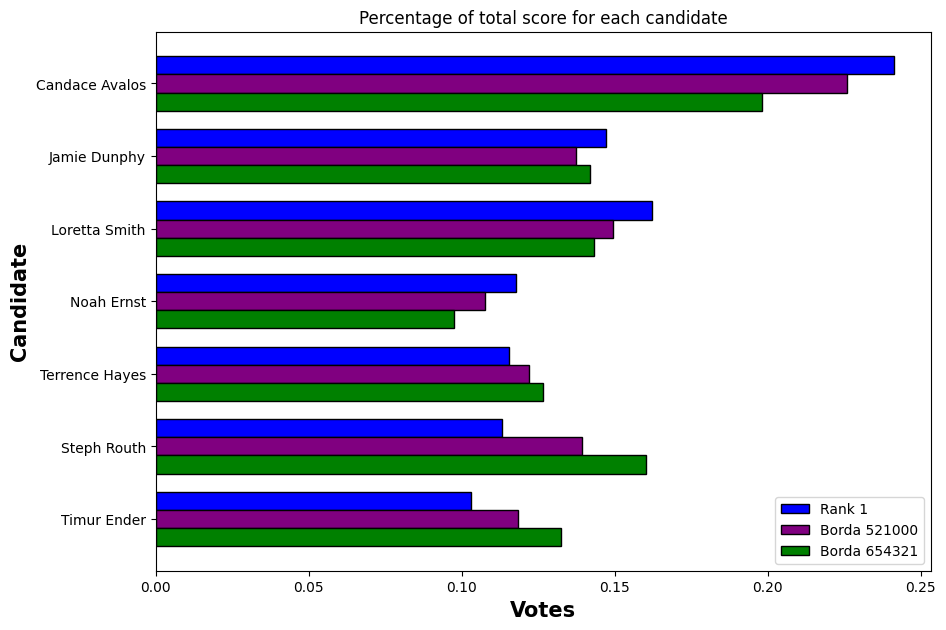

In [17]:
fig = plt.subplots(figsize =(10, len(D1_candidates)))

barWidth = 0.25

# Set position of bar on Y axis
br2 = np.arange(len(D1_candidates))
br1 = [x + barWidth for x in br2]
br3= [x - barWidth for x in br2]


rank1_plot = plt.barh(br1, rank1_pct, color = 'blue', height = barWidth, edgecolor = 'black')
borda521000_plot = plt.barh(br2, borda521000_pct, color= 'purple', height = barWidth, edgecolor = 'black')
borda654321_plot = plt.barh(br3, borda654321_pct, color= 'green', height = barWidth, edgecolor = 'black')

plt.title('Percentage of total score for each candidate')

plt.ylabel('Candidate', fontweight ='bold', fontsize = 15)
plt.xlabel('Votes', fontweight ='bold', fontsize = 15)
plt.yticks(ind, tuple(D1_candidates_reversed))

plt.legend((rank1_plot[0], borda521000_plot[0], borda654321_plot[0]), 
           ('Rank 1', 'Borda 521000', 'Borda 654321'))


plt.show()

### Construct voter percentage columns for each "election" (Rank 1, Borda, Ballot length):

In [18]:
for name in D1_candidates:
    D1_precincts_df[name + ' Rank 1 pct'] = D1_precincts_df[name + ' Condensed Rank 1']/D1_precincts_df['Condensed total votes']
    D1_precincts_df[name + ' Borda 654321 pct' ] = D1_precincts_df[name + ' Condensed Borda 654321']/D1_precincts_df['Condensed Borda 654321 total']
    D1_precincts_df[name + ' Borda 521000 pct' ] = D1_precincts_df[name + ' Condensed Borda 521000']/D1_precincts_df['Condensed Borda 521000 total']

for r in [1,2,3,4,5,6]:
    D1_precincts_df['Ballot length ' + str(r) + ' pct'] = D1_precincts_df['Ballot length ' + str(r)]/D1_precincts_df['Ballot length total']
    

### Do both Goodman's ER (with precincts weighted by population) and EI.
### For each candidate, do each minority racial group separately, as well as POC combined.

### Rank 1 scores:

Candace Avalos , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Candace Avalos is
        0.276
        Est. fraction of non- POC
        voters who voted for Candace Avalos is
        0.148
        
Jamie Dunphy , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Jamie Dunphy is
        0.184
        Est. fraction of non- POC
        voters who voted for Jamie Dunphy is
        0.081
        
Loretta Smith , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Loretta Smith is
        0.119
        Est. fraction of non- POC
        voters who voted for Loretta Smith is
        0.137
        
Noah Ernst , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Noah Ernst is
        0.080
        Est. fraction of non- POC
        voters who voted for Noah Ernst is
        0.102
        
Terrence Hayes , 

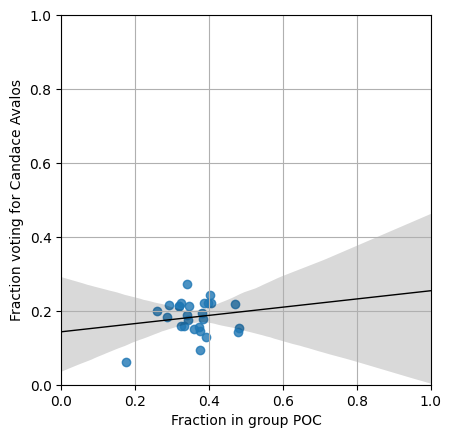

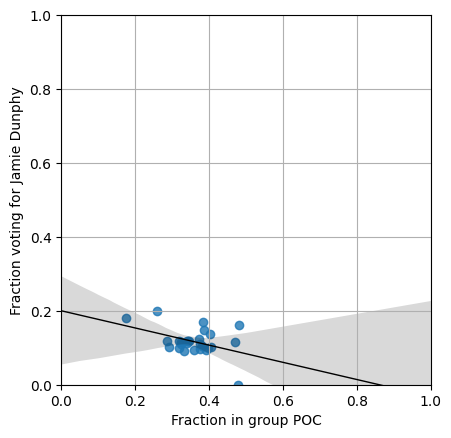

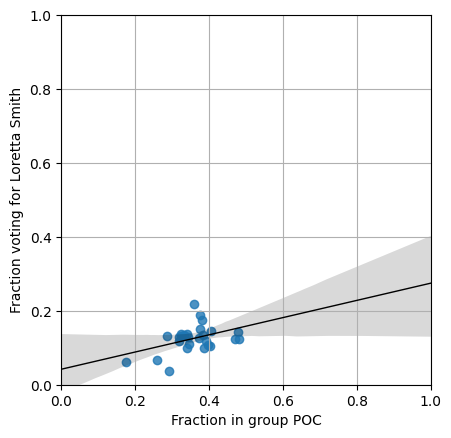

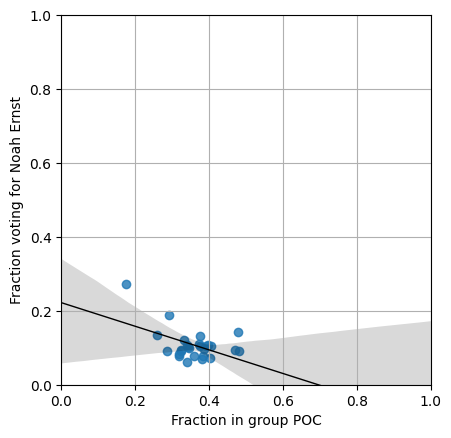

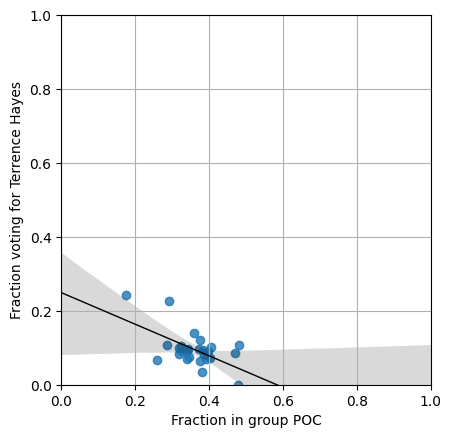

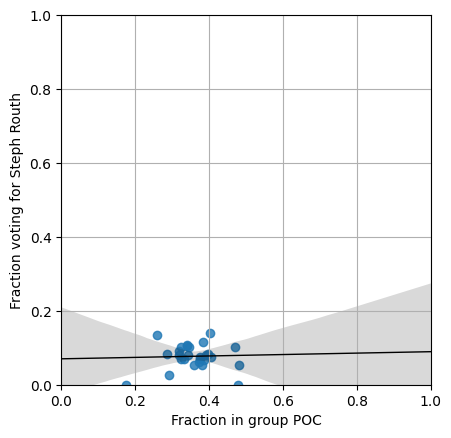

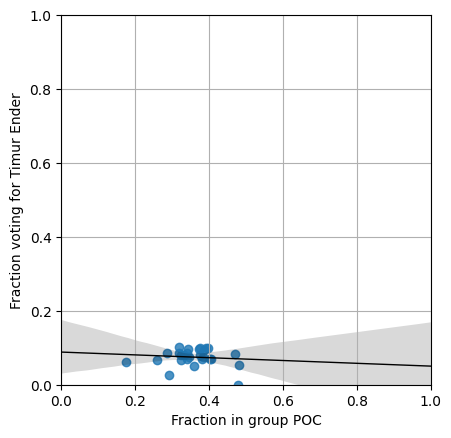

In [19]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Rank 1"
election_total_votes = "Condensed total votes"

pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "AMIN": "AMINDVAP22 pct",
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(len(D1_candidates)):
    for demographic_group_name in demographic_groups:   
        candidate_name = D1_candidates[i]
        votes_fraction = np.array(D1_precincts_df[candidate_name + " " + election + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting Goodman's ER - precincts weighted by population
        # Create a GoodmansER object
        goodmans_er = GoodmansER(is_weighted_regression=True)

        # Fit the model
        goodmans_er.fit(
            group_fraction,
            votes_fraction,
            precinct_votes,
            demographic_group_name=demographic_group_name,
            candidate_name=candidate_name
         )

        goodmans_er.plot(line_kws={"color":"black", "lw": 1})
        
        # Generate a simple report to summarize the results
        print(goodmans_er.summary())
    

### Now do 2x2 EI, one candidate/election at a time.

Candace Avalos , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

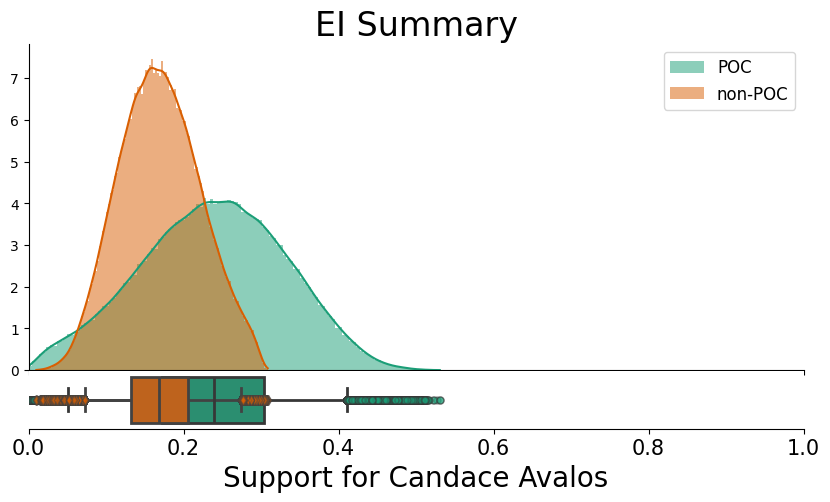

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Candace Avalos is
        0.237
        The posterior mean for the district-level voting preference of
        non-POC for Candace Avalos is
        0.169
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Candace Avalos is
        [0.05050654 0.41032406]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Candace Avalos is
        [0.07291836 0.27443109]
        
Jamie Dunphy , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

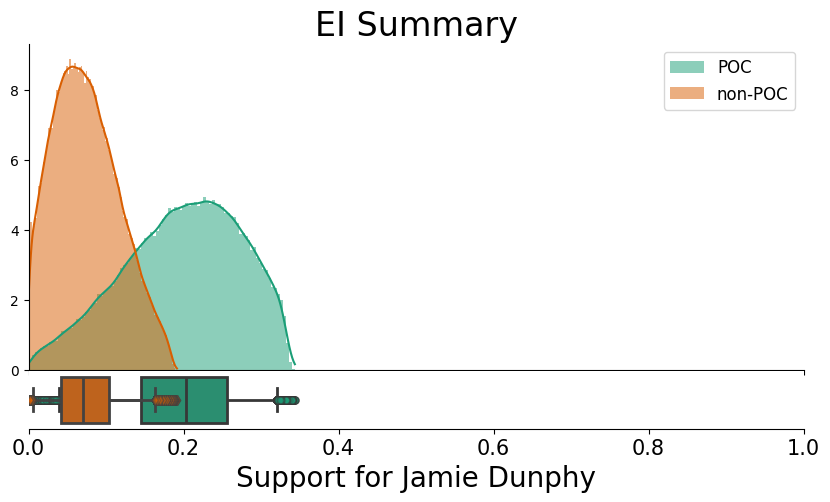

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Jamie Dunphy is
        0.197
        The posterior mean for the district-level voting preference of
        non-POC for Jamie Dunphy is
        0.075
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Jamie Dunphy is
        [0.03933457 0.32108223]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Jamie Dunphy is
        [0.00603535 0.16319981]
        
Loretta Smith , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

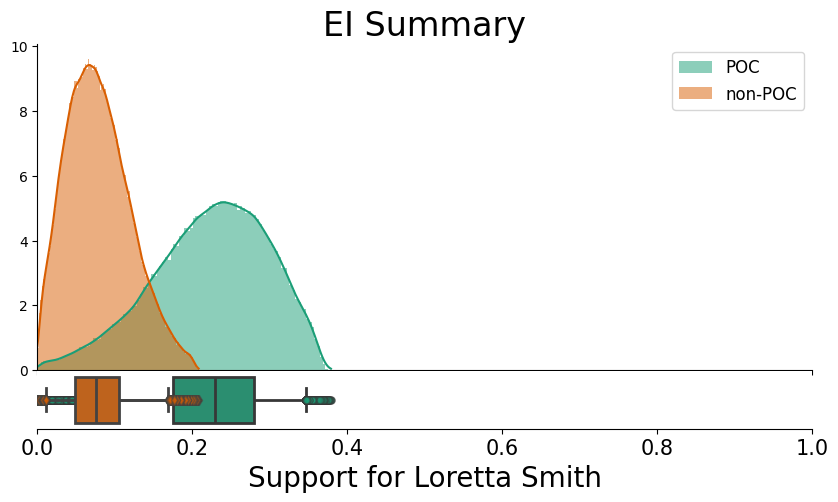

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Loretta Smith is
        0.223
        The posterior mean for the district-level voting preference of
        non-POC for Loretta Smith is
        0.079
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Loretta Smith is
        [0.06108551 0.34611036]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Loretta Smith is
        [0.01160687 0.16919513]
        
Noah Ernst , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

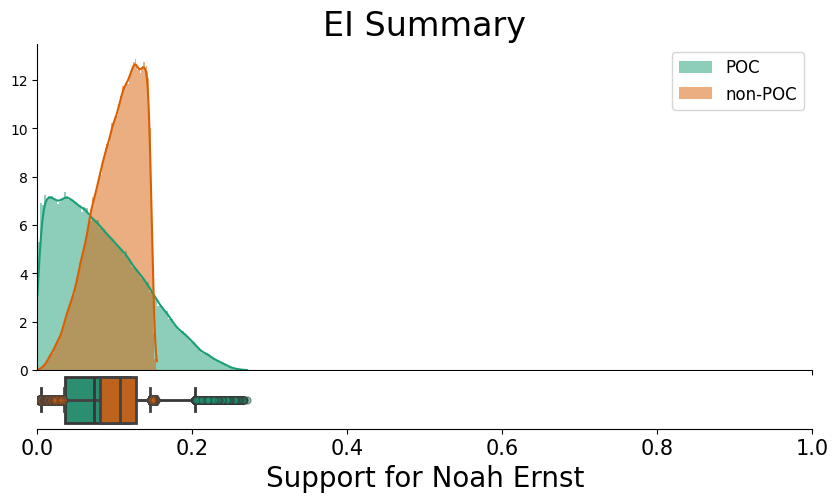

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Noah Ernst is
        0.082
        The posterior mean for the district-level voting preference of
        non-POC for Noah Ernst is
        0.102
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Noah Ernst is
        [0.00429539 0.20317008]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Noah Ernst is
        [0.0346317  0.14583195]
        
Terrence Hayes , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

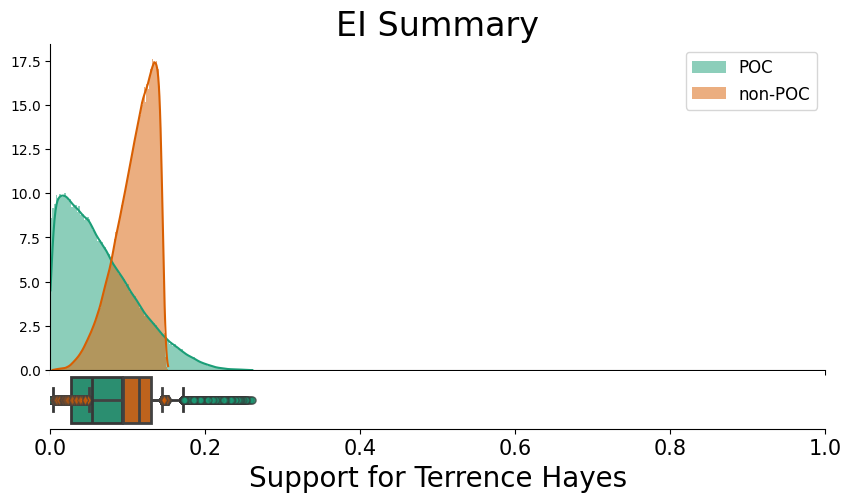

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Terrence Hayes is
        0.063
        The posterior mean for the district-level voting preference of
        non-POC for Terrence Hayes is
        0.109
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Terrence Hayes is
        [0.0028704  0.17083154]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Terrence Hayes is
        [0.04948431 0.14380722]
        
Steph Routh , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

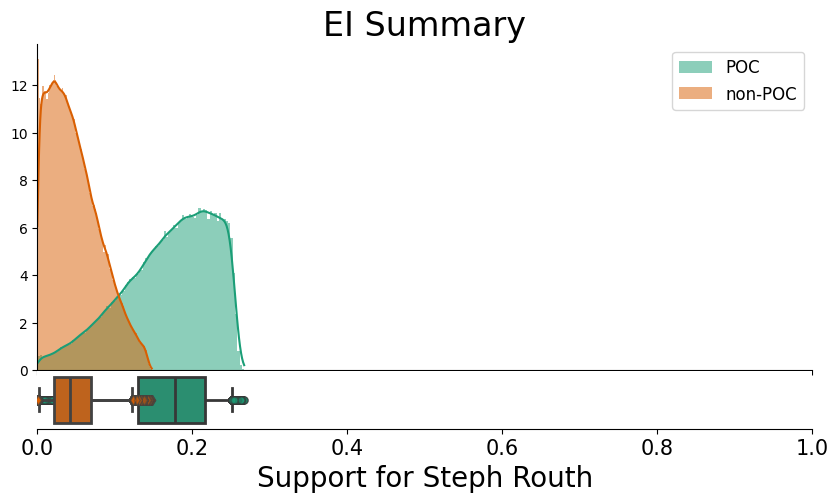

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Steph Routh is
        0.168
        The posterior mean for the district-level voting preference of
        non-POC for Steph Routh is
        0.048
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Steph Routh is
        [0.03518692 0.25149218]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Steph Routh is
        [0.00195783 0.12260545]
        
Timur Ender , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

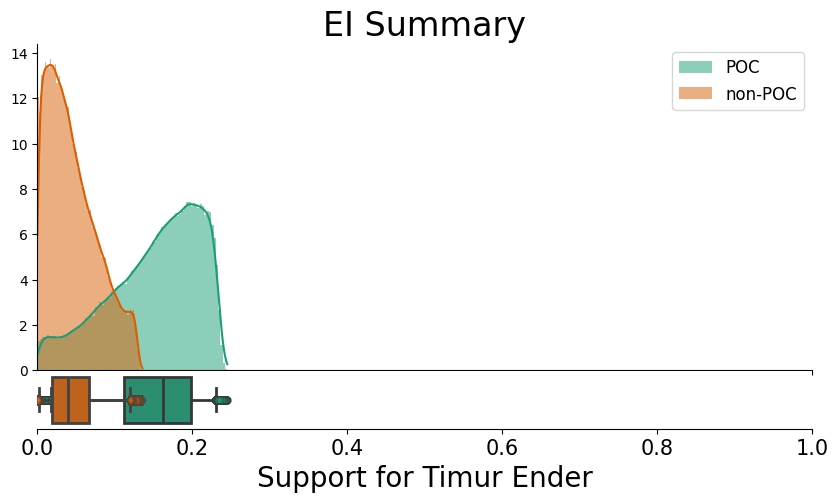

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Timur Ender is
        0.150
        The posterior mean for the district-level voting preference of
        non-POC for Timur Ender is
        0.046
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Timur Ender is
        [0.01767907 0.23041144]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Timur Ender is
        [0.00213531 0.11948884]
        
Other , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

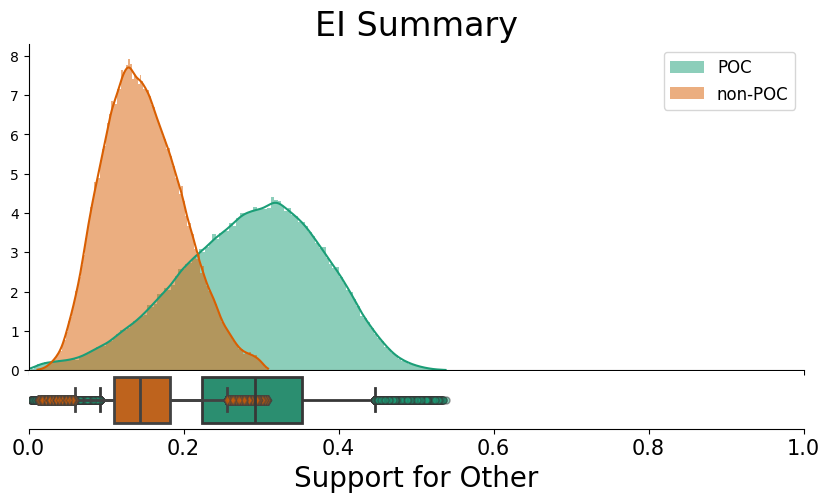

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Other is
        0.286
        The posterior mean for the district-level voting preference of
        non-POC for Other is
        0.148
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Other is
        [0.09173677 0.44637774]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Other is
        [0.05966595 0.2557766 ]
        


In [20]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Rank 1"
election_total_votes = "Condensed total votes"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)

pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(len(candidate_names)):
    for demographic_group_name in demographic_groups:   
        candidate_name = candidate_names[i]
        votes_fraction = np.array(D1_precincts_df[candidate_name + " " + election + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting a first 2 x 2 model

         # Create a TwobyTwoEI object
        ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=50, pareto_shape=10)

        # Fit the model
        ei_2by2.fit(group_fraction,
                votes_fraction,
                precinct_votes,
                demographic_group_name=demographic_group_name,
                candidate_name=candidate_name,
                precinct_names=precinct_names,
                draws=50000, # optional
                tune=10000, # optional
                target_accept=.999# optional
        )

        ei_2by2.plot()
        plt.show()

        # Plot the rhat and ess statistics and plot trace to see what's going on with these!
        #az.rhat(ei_2by2.sim_trace)
        #az.ess(ei_2by2.sim_trace)
        #az.plot_trace(ei_2by2.sim_trace, compact=True)

        # Generate a simple report to summarize the results
        print(ei_2by2.summary())

Running ['Hispanic', 'Asian', 'Black', 'White+Other'] x ['Candace Avalos', 'Jamie Dunphy', 'Loretta Smith', 'Noah Ernst', 'Terrence Hayes', 'Steph Routh', 'Timur Ender', 'Other'] EI
r = 4 rows (demographic groups)
c = 8 columns (candidates or voting outcomes)
number of precincts = 27


  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:910: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,50000,27,4,7]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


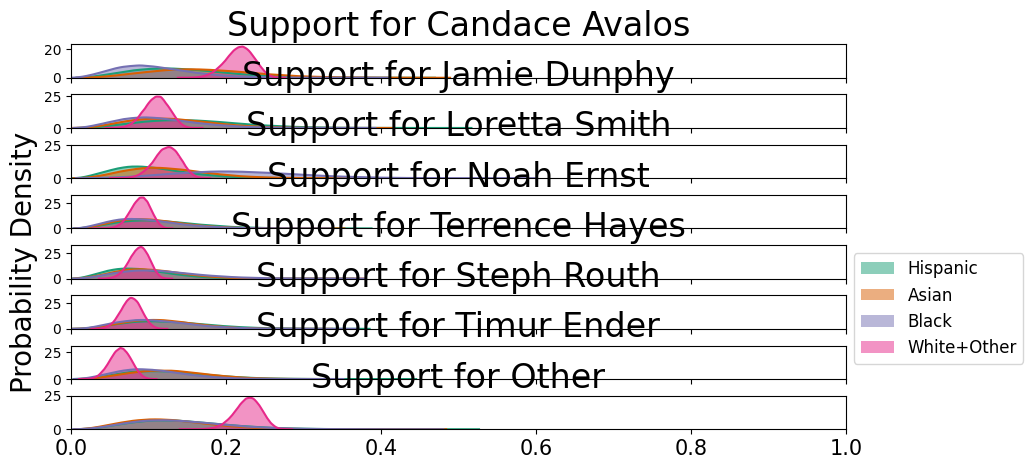


            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                Hispanic for Candace Avalos is
                0.142
                95% equal-tailed credible interval:  [0.04260267 0.27969683]
                The posterior mean for the district-level voting preference of
                Hispanic for Jamie Dunphy is
                0.156
                95% equal-tailed credible interval:  [0.04905965 0.29751409]
                The posterior mean for the district-level voting preference of
                Hispanic for Loretta Smith is
                0.105
                95% equal-tailed credible interval:  [0.02979465 0.21375328]
                The posterior mean for the district-level voting preference of
                Hispanic for Noah Ernst is
              

In [21]:
precinct_names = D1_precincts_df['Precinct']
demographic_group_names = ["Hispanic", "Asian", "Black", "White+Other"]
election = "Rank 1"
election_total_votes = "Condensed total votes"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)

D1_precincts_df['W+ODVAP22 pct'] = 1 - D1_precincts_df[['HDVAP22 pct', 'AAPIDVAP22 pct', 'BDVAP22 pct']].sum(axis=1)

votes_fractions = np.array(D1_precincts_df[[name + " " + election + " pct" for name in candidate_names]]).T
precinct_votes = np.array(D1_precincts_df[election_total_votes])

group_fractions = np.array(D1_precincts_df[['HDVAP22 pct', 'AAPIDVAP22 pct', 'BDVAP22 pct', 'W+ODVAP22 pct']]).T

ei = RowByColumnEI(model_name='multinomial-dirichlet')
ei.fit(group_fractions, votes_fractions, precinct_votes, demographic_group_names, candidate_names, draws=50000, target_accept=.999)

ei.plot()
plt.show()
print(ei.summary())

#ei.precinct_level_plot(D1_candidates[i])

### 2xC:

Running ['POC', 'White'] x ['Candace Avalos', 'Jamie Dunphy', 'Loretta Smith', 'Noah Ernst', 'Terrence Hayes', 'Steph Routh', 'Timur Ender', 'Other'] EI
r = 2 rows (demographic groups)
c = 8 columns (candidates or voting outcomes)
number of precincts = 27


  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:910: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,50000,27,2,7]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


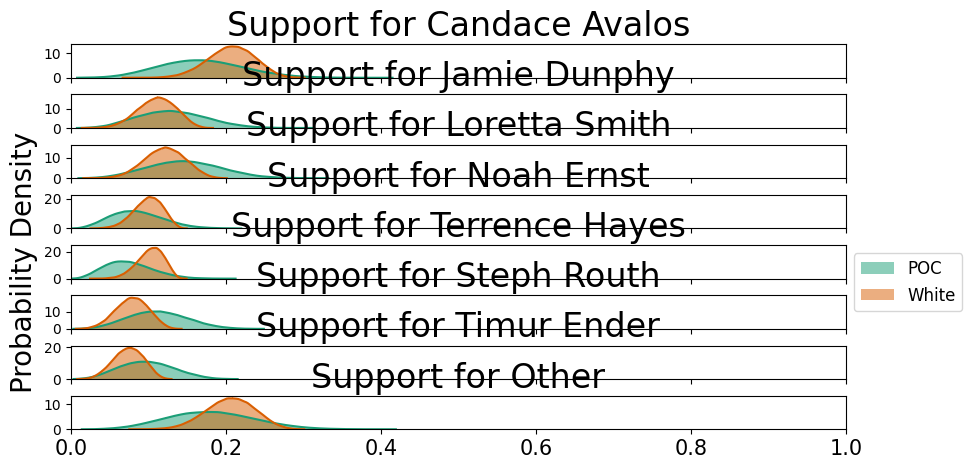


            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                POC for Candace Avalos is
                0.169
                95% equal-tailed credible interval:  [0.07062878 0.27967801]
                The posterior mean for the district-level voting preference of
                POC for Jamie Dunphy is
                0.131
                95% equal-tailed credible interval:  [0.0526213  0.21953425]
                The posterior mean for the district-level voting preference of
                POC for Loretta Smith is
                0.147
                95% equal-tailed credible interval:  [0.05974412 0.24029709]
                The posterior mean for the district-level voting preference of
                POC for Noah Ernst is
                0.086
            

In [22]:
precinct_names = D1_precincts_df['Precinct']
demographic_group_names = ["POC", "White"]
election = "Rank 1"
election_total_votes = "Condensed total votes"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)


votes_fractions = np.array(D1_precincts_df[[name + " " + election + " pct" for name in candidate_names]]).T
precinct_votes = np.array(D1_precincts_df[election_total_votes])

group_fractions = np.array(D1_precincts_df[['POCDVAP22 pct', 'WDVAP22 pct']]).T

ei = RowByColumnEI(model_name='multinomial-dirichlet')
ei.fit(group_fractions, votes_fractions, precinct_votes, demographic_group_names, candidate_names, draws=50000, target_accept=.999)

ei.plot()
plt.show()
print(ei.summary())

#ei.precinct_level_plot(D1_candidates[i])

### Not super informative!  Compared to 2x2 support for POC vs. White,
- Avalos has more POC support than White under 2x2, but reversed under 2xC. 
- Dunphy has more POC support under both models, but more pronounced under 2x2.
- Smith has more POC support under both models, but more pronounced under 2x2.
- Ernst has more White support under both models, with similar overlap.
- Hayes has more White support under both models, with similar overlap.
- Routh has more POC support under both models, but more pronounced under 2x2.
- Ender has more POC support under both models, but more pronounced under 2x2.
- Other has more POC support than White under 2x2, but reversed under 2xC. 




### Borda 654321 score:

### Goodman's ER, with plots.

Candace Avalos , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Candace Avalos is
        0.173
        Est. fraction of non- POC
        voters who voted for Candace Avalos is
        0.130
        
Jamie Dunphy , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Jamie Dunphy is
        0.143
        Est. fraction of non- POC
        voters who voted for Jamie Dunphy is
        0.083
        
Loretta Smith , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Loretta Smith is
        0.103
        Est. fraction of non- POC
        voters who voted for Loretta Smith is
        0.107
        
Noah Ernst , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Noah Ernst is
        0.046
        Est. fraction of non- POC
        voters who voted for Noah Ernst is
        0.086
        
Terrence Hayes , 

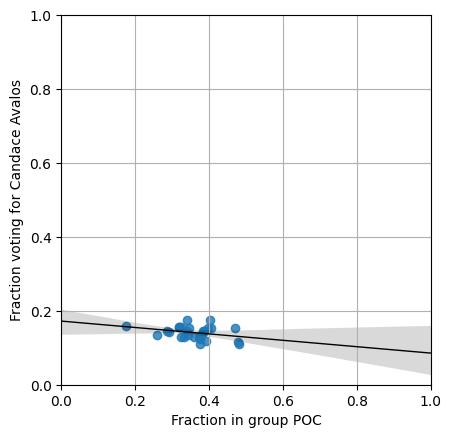

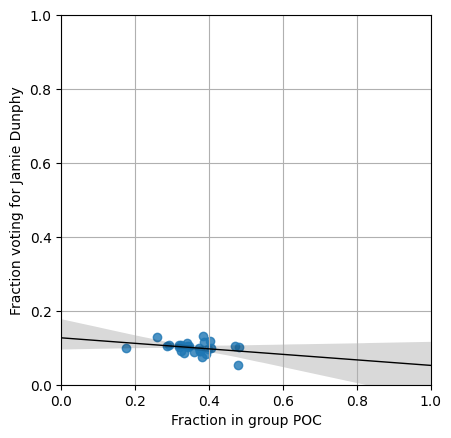

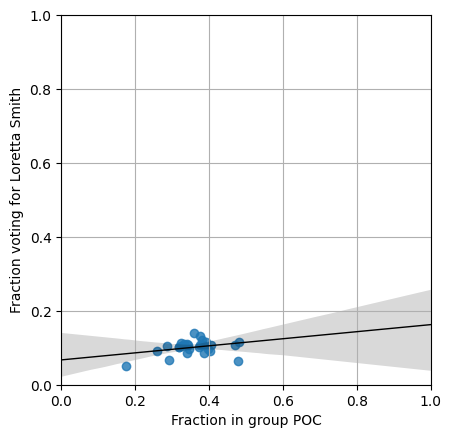

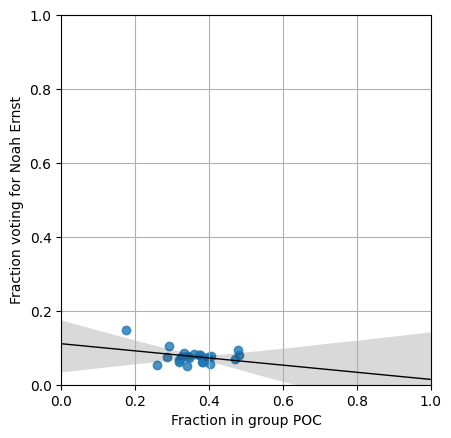

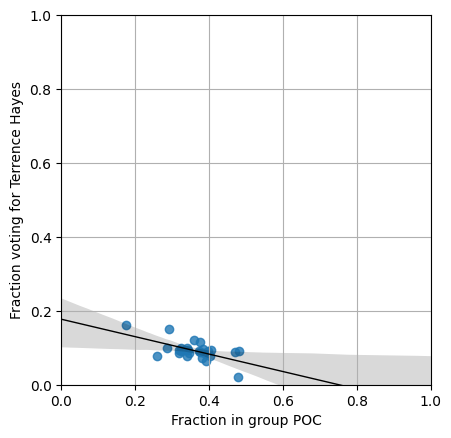

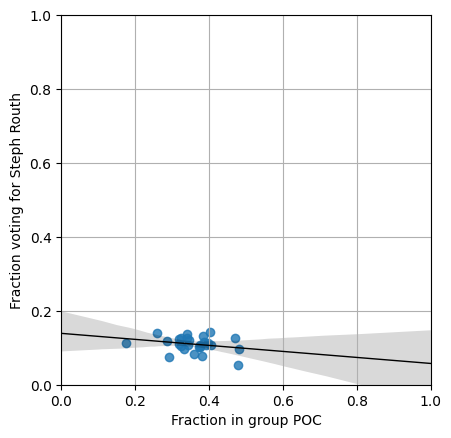

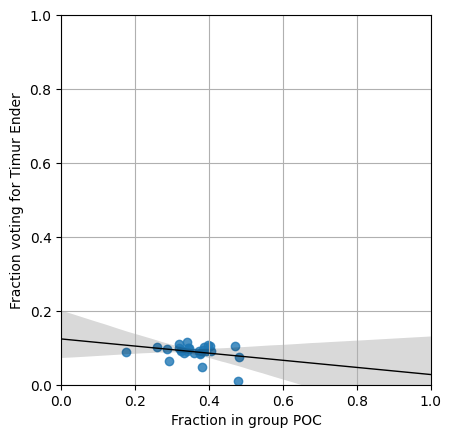

In [23]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Borda 654321"
election_total_votes = "Condensed Borda 654321 total"


pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "AMIN": "AMINDVAP22 pct",
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(len(D1_candidates)):
    for demographic_group_name in demographic_groups:   
        candidate_name = D1_candidates[i]
        votes_fraction = np.array(D1_precincts_df[candidate_name + " " + election + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting Goodman's ER - precincts weighted by population
        # Create a GoodmansER object
        goodmans_er = GoodmansER(is_weighted_regression=True)

        # Fit the model
        goodmans_er.fit(
            group_fraction,
            votes_fraction,
            precinct_votes,
            demographic_group_name=demographic_group_name,
            candidate_name=candidate_name
         )

        goodmans_er.plot(line_kws={"color":"black", "lw": 1})
        
        # Generate a simple report to summarize the results
        print(goodmans_er.summary())
    

### 2x2 EI:

Candace Avalos , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

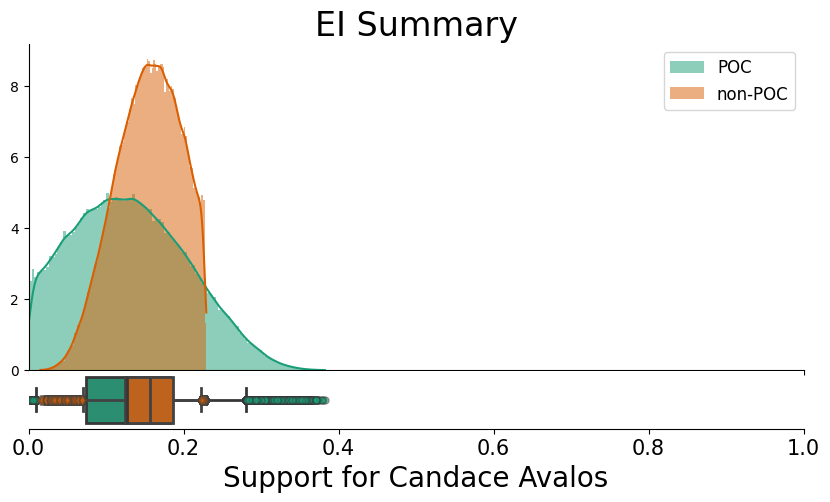

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Candace Avalos is
        0.131
        The posterior mean for the district-level voting preference of
        non-POC for Candace Avalos is
        0.154
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Candace Avalos is
        [0.00941481 0.28031667]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Candace Avalos is
        [0.07068076 0.22256934]
        
Jamie Dunphy , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

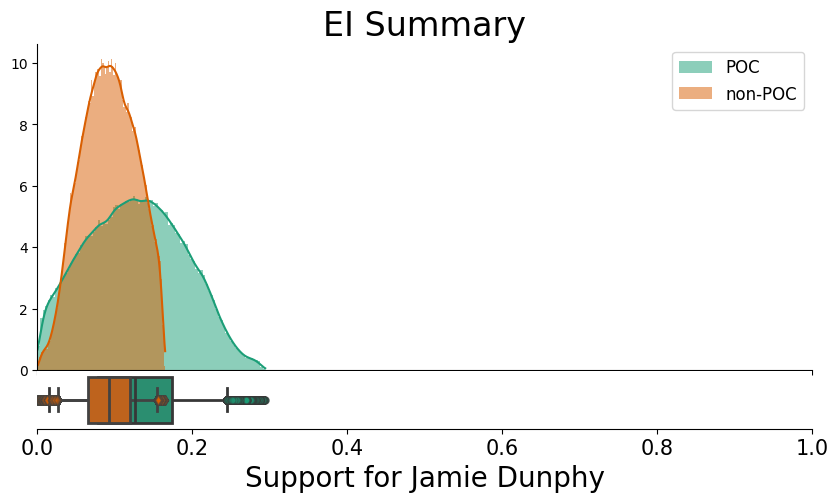

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Jamie Dunphy is
        0.127
        The posterior mean for the district-level voting preference of
        non-POC for Jamie Dunphy is
        0.092
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Jamie Dunphy is
        [0.01491737 0.24514809]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Jamie Dunphy is
        [0.02639482 0.1549155 ]
        
Loretta Smith , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


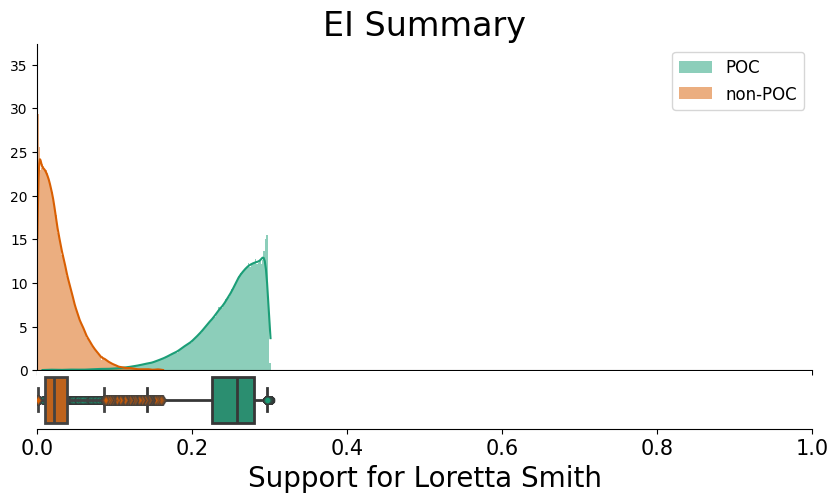

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Loretta Smith is
        0.247
        The posterior mean for the district-level voting preference of
        non-POC for Loretta Smith is
        0.027
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Loretta Smith is
        [0.14146979 0.29657333]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Loretta Smith is
        [0.00067619 0.08547034]
        
Noah Ernst , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


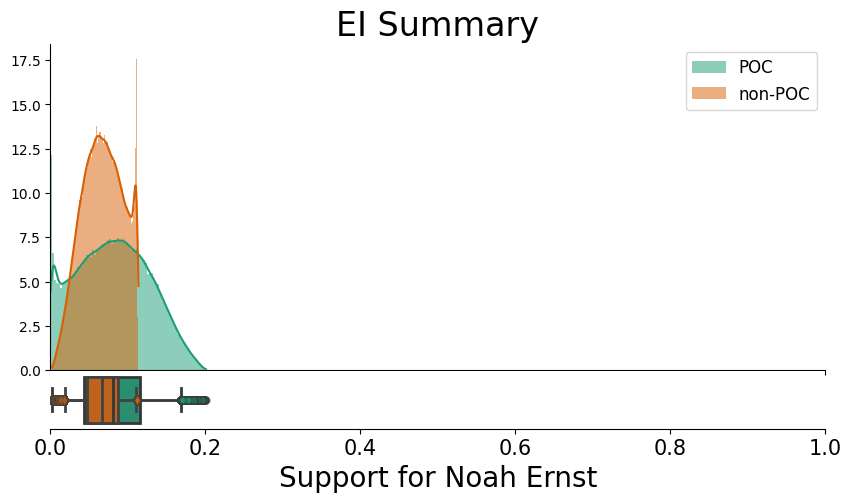

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Noah Ernst is
        0.081
        The posterior mean for the district-level voting preference of
        non-POC for Noah Ernst is
        0.067
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Noah Ernst is
        [0.00195203 0.16883417]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Noah Ernst is
        [0.01839247 0.11100043]
        
Terrence Hayes , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

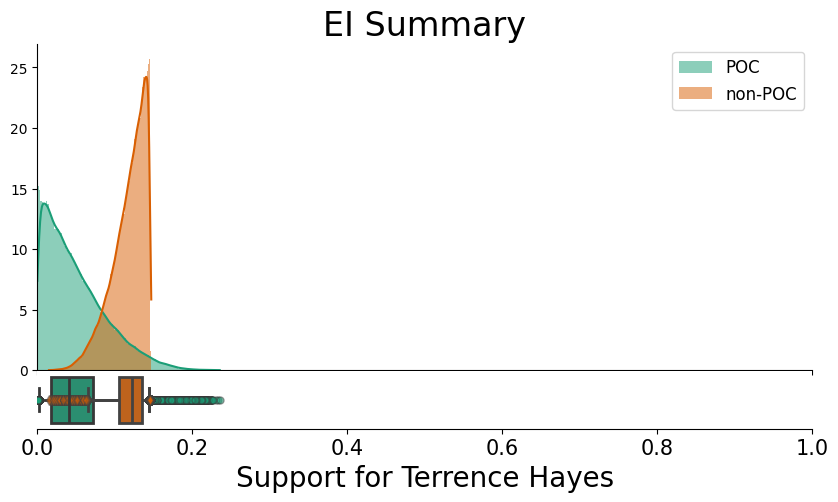

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Terrence Hayes is
        0.049
        The posterior mean for the district-level voting preference of
        non-POC for Terrence Hayes is
        0.118
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Terrence Hayes is
        [0.00164614 0.14382558]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Terrence Hayes is
        [0.06478954 0.14453106]
        
Steph Routh , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


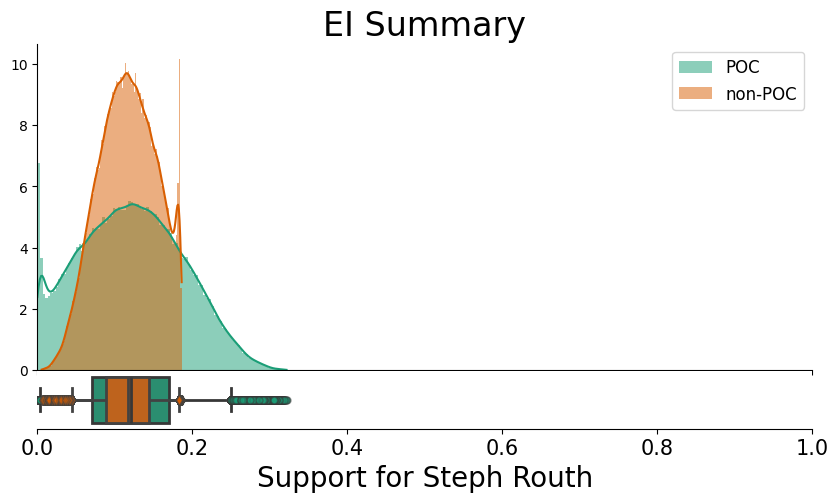

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Steph Routh is
        0.121
        The posterior mean for the district-level voting preference of
        non-POC for Steph Routh is
        0.116
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Steph Routh is
        [0.00385616 0.24938918]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Steph Routh is
        [0.04473071 0.18232974]
        
Timur Ender , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

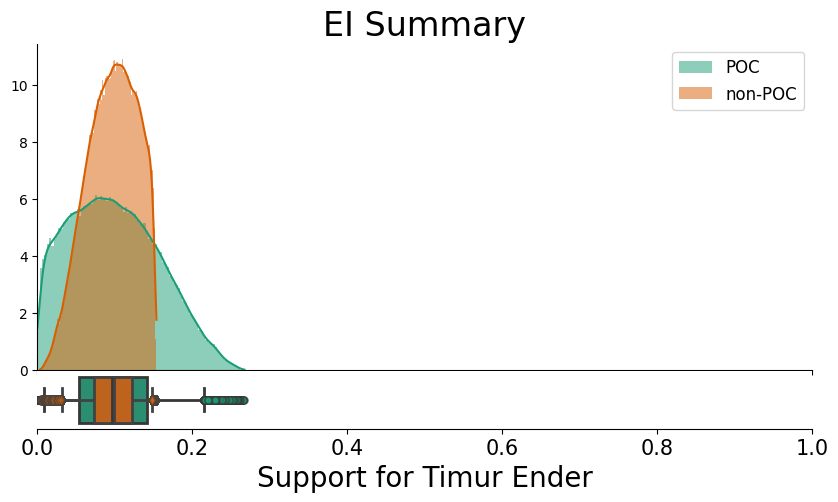

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Timur Ender is
        0.100
        The posterior mean for the district-level voting preference of
        non-POC for Timur Ender is
        0.097
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Timur Ender is
        [0.00811671 0.21553372]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Timur Ender is
        [0.03220208 0.14804965]
        
Other , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

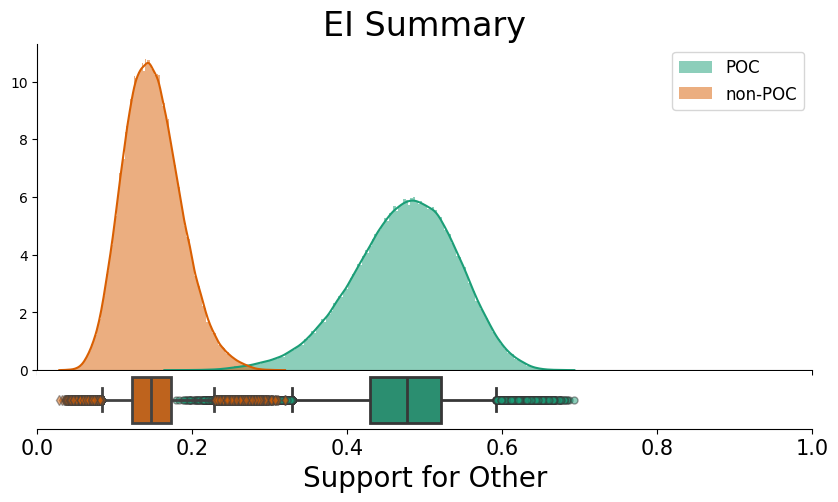

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Other is
        0.473
        The posterior mean for the district-level voting preference of
        non-POC for Other is
        0.149
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Other is
        [0.32888536 0.59239306]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Other is
        [0.08299901 0.2285696 ]
        


In [24]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Borda 654321"
election_total_votes = "Condensed Borda 654321 total"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)

pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(len(candidate_names)):
    for demographic_group_name in demographic_groups:   
        candidate_name = candidate_names[i]
        votes_fraction = np.array(D1_precincts_df[candidate_name + " " + election + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting a first 2 x 2 model

         # Create a TwobyTwoEI object
        ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=50, pareto_shape=10)

        # Fit the model
        ei_2by2.fit(group_fraction,
                votes_fraction,
                precinct_votes,
                demographic_group_name=demographic_group_name,
                candidate_name=candidate_name,
                precinct_names=precinct_names,
                draws=50000, # optional
                tune=10000, # optional
                target_accept=.999# optional
        )

        ei_2by2.plot()
        plt.show()

        # Plot the rhat and ess statistics and plot trace to see what's going on with these!
        #az.rhat(ei_2by2.sim_trace)
        #az.ess(ei_2by2.sim_trace)
        #az.plot_trace(ei_2by2.sim_trace, compact=True)

        # Generate a simple report to summarize the results
        print(ei_2by2.summary())

### Initial thoughts:
- POC vs. non-POC support for Avalos is reversed from in the Rank 1 version, but lots of overlap for both.
- Dunphy still does slightly better with POC than with White, but with a lot more overlap.
- Smith does more better with POC than in Rank 1 (but there are errors).
- Ernst has almost total overlap between White and POC distributions.
- Hayes still has more White support.
- Routh has almost total overlap between White and POC distributions.
- Ender has almost total overlap between White and POC distributions.
- Other has a LOT more POC support than in Rank 1, especially from Hispanic and Black - but not Asian.

### 2xC with POC combined:

Running ['POC', 'White'] x ['Candace Avalos', 'Jamie Dunphy', 'Loretta Smith', 'Noah Ernst', 'Terrence Hayes', 'Steph Routh', 'Timur Ender', 'Other'] EI
r = 2 rows (demographic groups)
c = 8 columns (candidates or voting outcomes)
number of precincts = 27


  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:910: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,50000,27,2,7]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


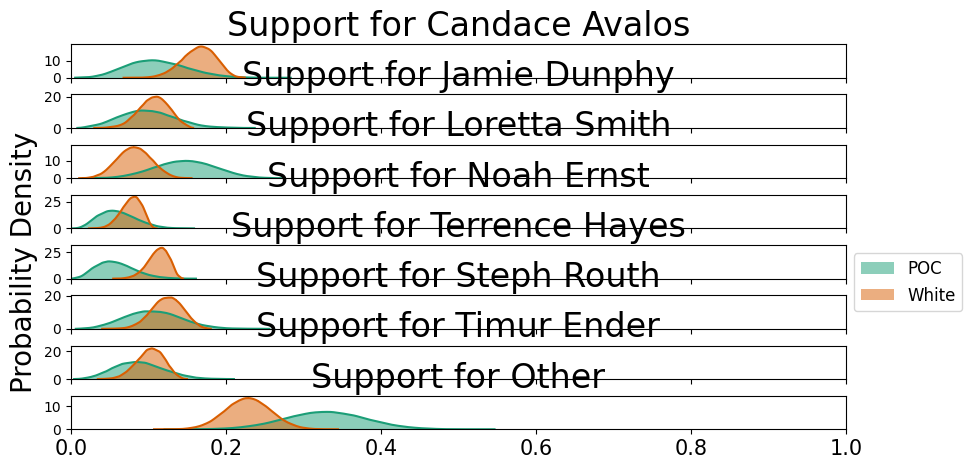


            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                POC for Candace Avalos is
                0.111
                95% equal-tailed credible interval:  [0.04324551 0.19134831]
                The posterior mean for the district-level voting preference of
                POC for Jamie Dunphy is
                0.099
                95% equal-tailed credible interval:  [0.03535777 0.17024618]
                The posterior mean for the district-level voting preference of
                POC for Loretta Smith is
                0.148
                95% equal-tailed credible interval:  [0.07339641 0.22134659]
                The posterior mean for the district-level voting preference of
                POC for Noah Ernst is
                0.061
            

In [25]:
precinct_names = D1_precincts_df['Precinct']
demographic_group_names = ["POC", "White"]
election = "Borda 654321"
election_total_votes = "Condensed Borda 654321 total"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)


votes_fractions = np.array(D1_precincts_df[[name + " " + election + " pct" for name in candidate_names]]).T
precinct_votes = np.array(D1_precincts_df[election_total_votes])

group_fractions = np.array(D1_precincts_df[['POCDVAP22 pct', 'WDVAP22 pct']]).T

ei = RowByColumnEI(model_name='multinomial-dirichlet')
ei.fit(group_fractions, votes_fractions, precinct_votes, demographic_group_names, candidate_names, draws=50000, target_accept=.999)

ei.plot()
plt.show()
print(ei.summary())

#ei.precinct_level_plot(D1_candidates[i])

### Borda 52100 score:

### Goodman's ER (with plots):

Candace Avalos , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Candace Avalos is
        0.225
        Est. fraction of non- POC
        voters who voted for Candace Avalos is
        0.149
        
Jamie Dunphy , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Jamie Dunphy is
        0.158
        Est. fraction of non- POC
        voters who voted for Jamie Dunphy is
        0.079
        
Loretta Smith , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Loretta Smith is
        0.112
        Est. fraction of non- POC
        voters who voted for Loretta Smith is
        0.119
        
Noah Ernst , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Noah Ernst is
        0.061
        Est. fraction of non- POC
        voters who voted for Noah Ernst is
        0.097
        
Terrence Hayes , 

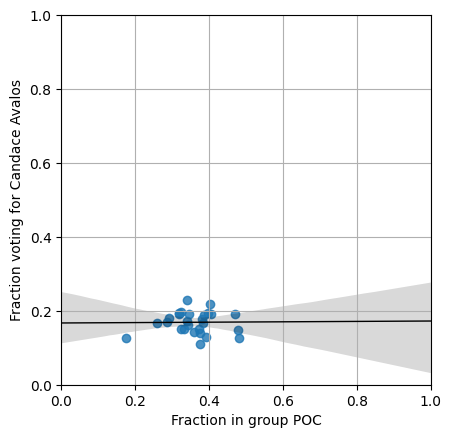

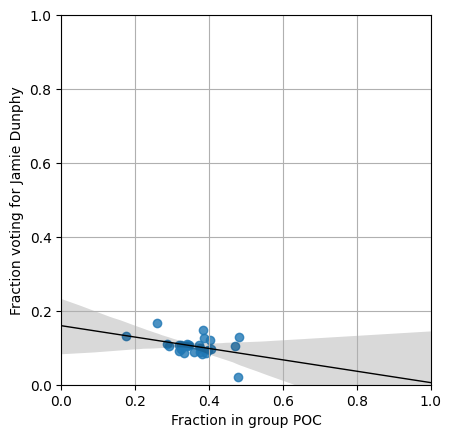

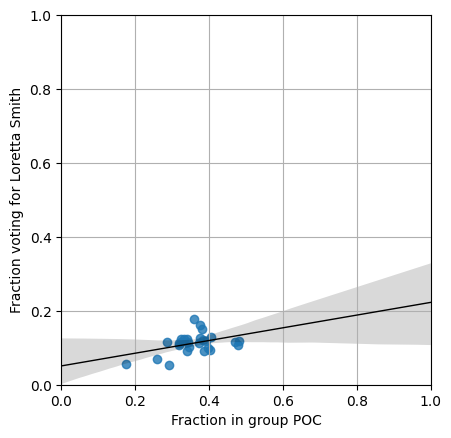

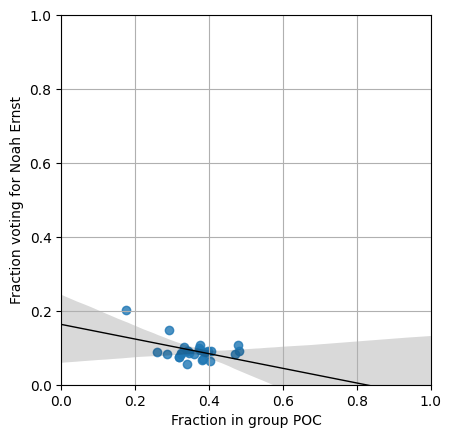

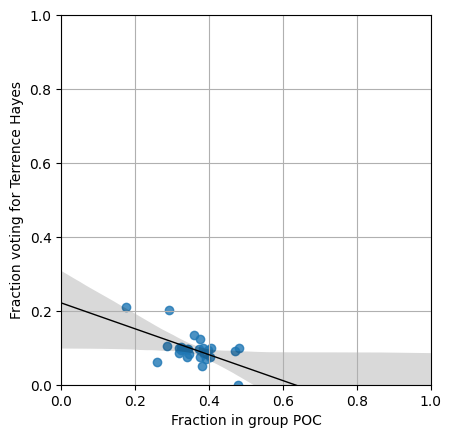

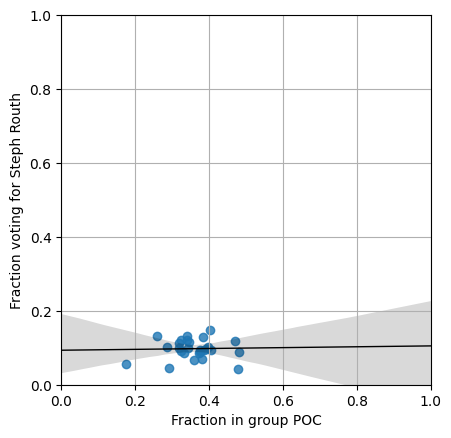

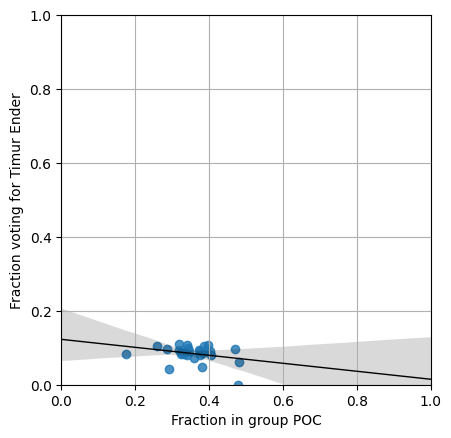

In [26]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Borda 521000"
election_total_votes = "Condensed Borda 521000 total"


pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "AMIN": "AMINDVAP22 pct",
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(len(D1_candidates)):
    for demographic_group_name in demographic_groups:   
        candidate_name = D1_candidates[i]
        votes_fraction = np.array(D1_precincts_df[candidate_name + " " + election + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting Goodman's ER - precincts weighted by population
        # Create a GoodmansER object
        goodmans_er = GoodmansER(is_weighted_regression=True)

        # Fit the model
        goodmans_er.fit(
            group_fraction,
            votes_fraction,
            precinct_votes,
            demographic_group_name=demographic_group_name,
            candidate_name=candidate_name
         )

        goodmans_er.plot(line_kws={"color":"black", "lw": 1})
        
        # Generate a simple report to summarize the results
        print(goodmans_er.summary())
    

### 2x2 EI:

Candace Avalos , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

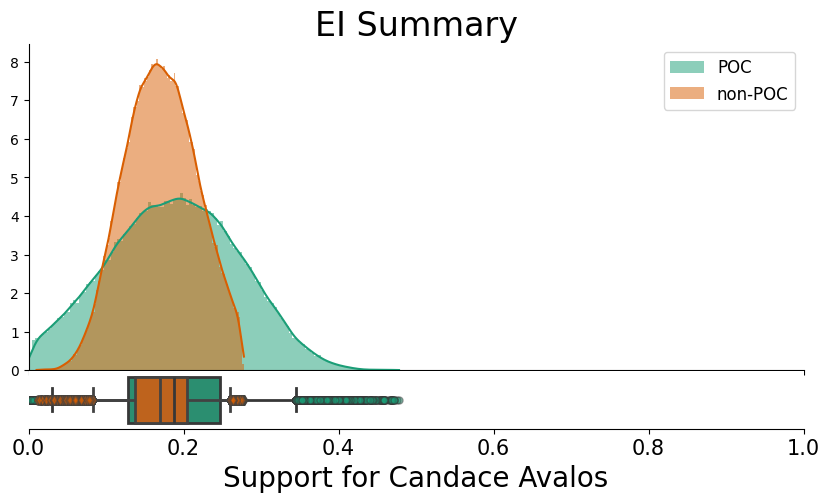

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Candace Avalos is
        0.187
        The posterior mean for the district-level voting preference of
        non-POC for Candace Avalos is
        0.171
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Candace Avalos is
        [0.02977161 0.34477254]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Candace Avalos is
        [0.08274908 0.2594378 ]
        
Jamie Dunphy , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

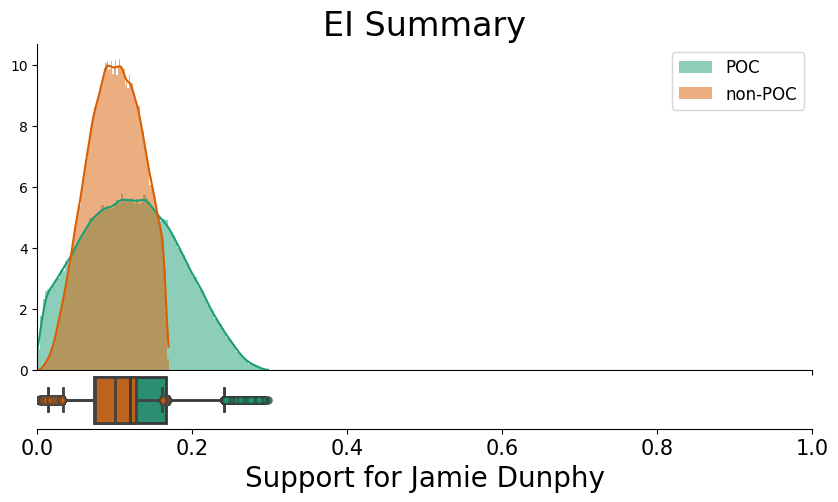

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Jamie Dunphy is
        0.121
        The posterior mean for the district-level voting preference of
        non-POC for Jamie Dunphy is
        0.100
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Jamie Dunphy is
        [0.01365177 0.24096499]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Jamie Dunphy is
        [0.03322375 0.16045097]
        
Loretta Smith , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


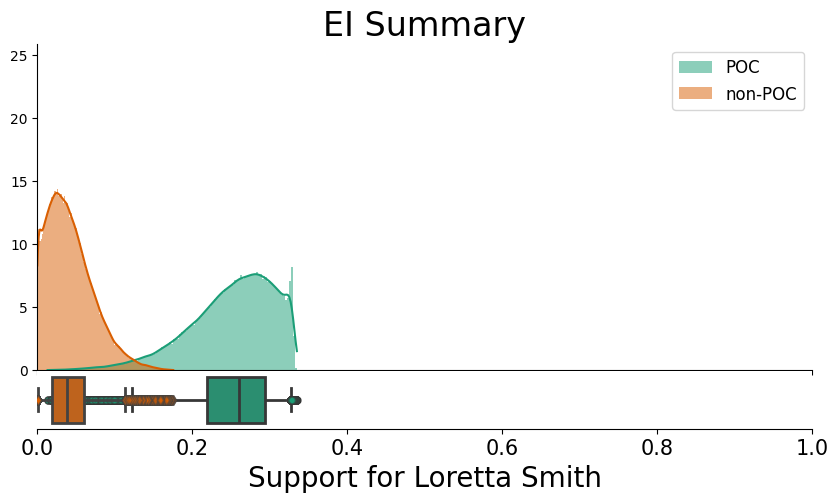

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Loretta Smith is
        0.251
        The posterior mean for the district-level voting preference of
        non-POC for Loretta Smith is
        0.042
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Loretta Smith is
        [0.12269592 0.3276443 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Loretta Smith is
        [0.00077999 0.11343457]
        
Noah Ernst , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

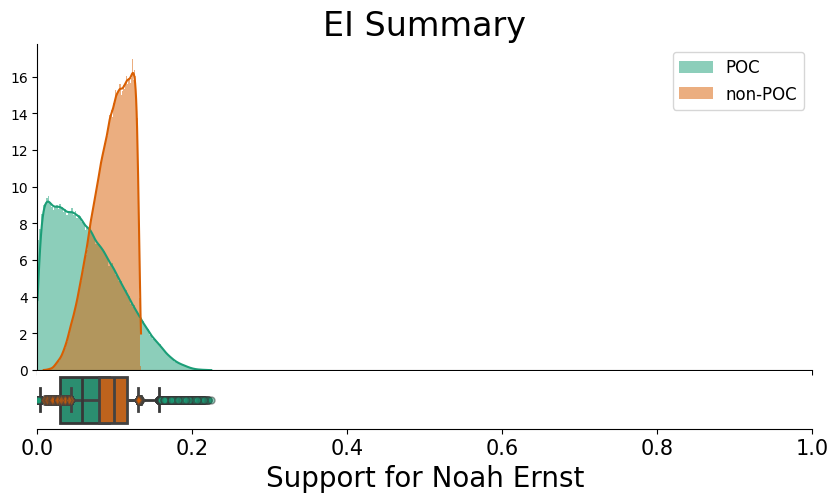

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Noah Ernst is
        0.064
        The posterior mean for the district-level voting preference of
        non-POC for Noah Ernst is
        0.096
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Noah Ernst is
        [0.00344114 0.15733101]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Noah Ernst is
        [0.04353546 0.12942609]
        
Terrence Hayes , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


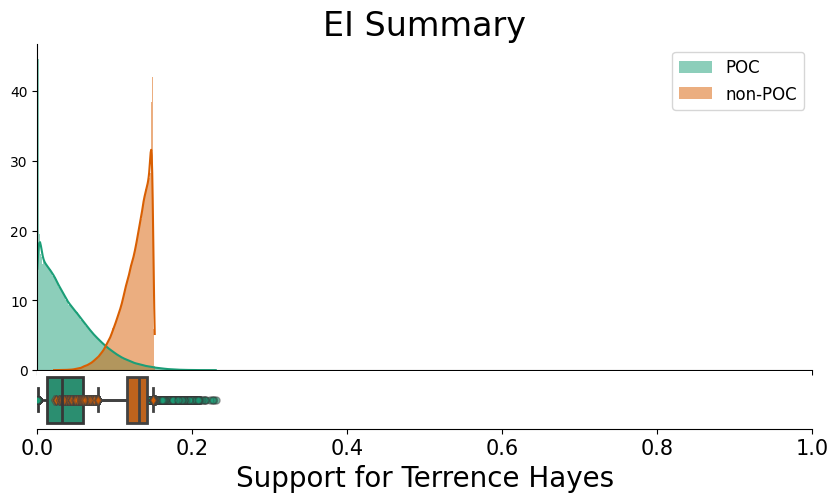

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Terrence Hayes is
        0.040
        The posterior mean for the district-level voting preference of
        non-POC for Terrence Hayes is
        0.126
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Terrence Hayes is
        [0.00025829 0.12476492]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Terrence Hayes is
        [0.0787146  0.14885285]
        
Steph Routh , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

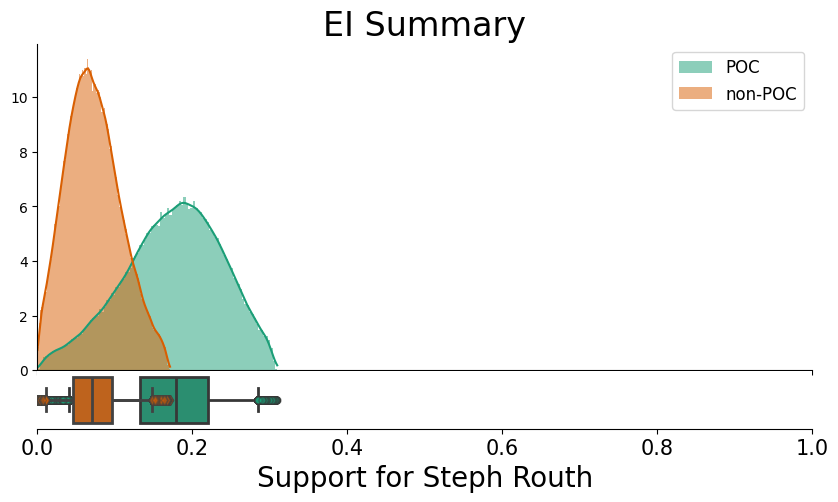

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Steph Routh is
        0.174
        The posterior mean for the district-level voting preference of
        non-POC for Steph Routh is
        0.073
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Steph Routh is
        [0.04086349 0.28430611]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Steph Routh is
        [0.01178007 0.14731741]
        
Timur Ender , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

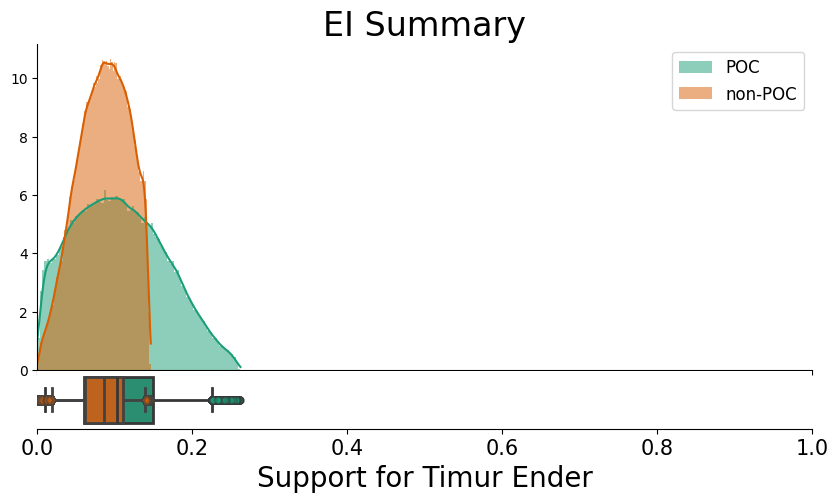

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Timur Ender is
        0.107
        The posterior mean for the district-level voting preference of
        non-POC for Timur Ender is
        0.085
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Timur Ender is
        [0.01005942 0.22524909]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Timur Ender is
        [0.01928987 0.13900993]
        
Other , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

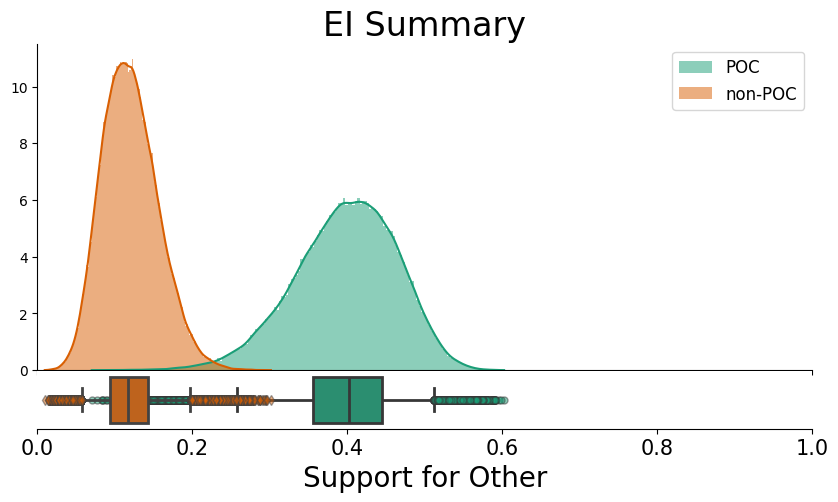

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Other is
        0.398
        The posterior mean for the district-level voting preference of
        non-POC for Other is
        0.120
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Other is
        [0.25812986 0.51239472]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Other is
        [0.05734904 0.19709648]
        


In [27]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Borda 521000"
election_total_votes = "Condensed Borda 521000 total"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)

pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(len(candidate_names)):
    for demographic_group_name in demographic_groups:   
        candidate_name = candidate_names[i]
        votes_fraction = np.array(D1_precincts_df[candidate_name + " " + election + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting a first 2 x 2 model

         # Create a TwobyTwoEI object
        ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=50, pareto_shape=10)

        # Fit the model
        ei_2by2.fit(group_fraction,
                votes_fraction,
                precinct_votes,
                demographic_group_name=demographic_group_name,
                candidate_name=candidate_name,
                precinct_names=precinct_names,
                draws=50000, # optional
                tune=10000, # optional
                target_accept=.999# optional
        )

        ei_2by2.plot()
        plt.show()

        # Plot the rhat and ess statistics and plot trace to see what's going on with these!
        #az.rhat(ei_2by2.sim_trace)
        #az.ess(ei_2by2.sim_trace)
        #az.plot_trace(ei_2by2.sim_trace, compact=True)

        # Generate a simple report to summarize the results
        print(ei_2by2.summary())

### 2xC with POC combined:

Running ['POC', 'White'] x ['Candace Avalos', 'Jamie Dunphy', 'Loretta Smith', 'Noah Ernst', 'Terrence Hayes', 'Steph Routh', 'Timur Ender', 'Other'] EI
r = 2 rows (demographic groups)
c = 8 columns (candidates or voting outcomes)
number of precincts = 27


  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:910: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,50000,27,2,7]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


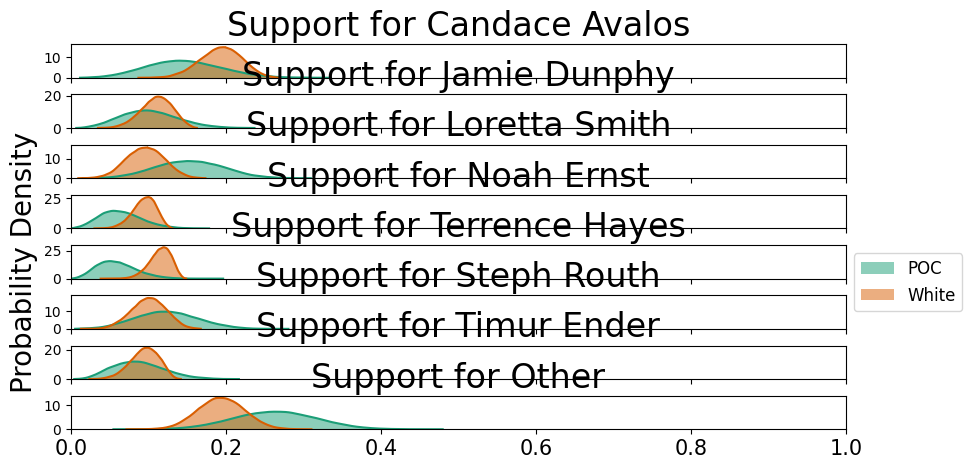


            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                POC for Candace Avalos is
                0.146
                95% equal-tailed credible interval:  [0.05854367 0.24305134]
                The posterior mean for the district-level voting preference of
                POC for Jamie Dunphy is
                0.101
                95% equal-tailed credible interval:  [0.03670719 0.17631537]
                The posterior mean for the district-level voting preference of
                POC for Loretta Smith is
                0.153
                95% equal-tailed credible interval:  [0.07038698 0.23693674]
                The posterior mean for the district-level voting preference of
                POC for Noah Ernst is
                0.065
            

In [28]:
precinct_names = D1_precincts_df['Precinct']
demographic_group_names = ["POC", "White"]
election = "Borda 521000"
election_total_votes = "Condensed Borda 521000 total"

candidate_names = D1_candidates + ["Other"]
D1_precincts_df["Other " + election + " pct"] = 1 - D1_precincts_df[[name + " " + election + " pct" for name in D1_candidates]].sum(axis=1)


votes_fractions = np.array(D1_precincts_df[[name + " " + election + " pct" for name in candidate_names]]).T
precinct_votes = np.array(D1_precincts_df[election_total_votes])

group_fractions = np.array(D1_precincts_df[['POCDVAP22 pct', 'WDVAP22 pct']]).T

ei = RowByColumnEI(model_name='multinomial-dirichlet')
ei.fit(group_fractions, votes_fractions, precinct_votes, demographic_group_names, candidate_names, draws=50000, target_accept=.999)

ei.plot()
plt.show()
print(ei.summary())

#ei.precinct_level_plot(D1_candidates[i])

### Ballot length:

### Goodman's ER (with plots):

Ballot length 1 , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Ballot length 1 is
        0.049
        Est. fraction of non- POC
        voters who voted for Ballot length 1 is
        0.186
        
Ballot length 2 , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Ballot length 2 is
        0.042
        Est. fraction of non- POC
        voters who voted for Ballot length 2 is
        0.088
        
Ballot length 3 , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Ballot length 3 is
        0.299
        Est. fraction of non- POC
        voters who voted for Ballot length 3 is
        0.137
        
Ballot length 4 , POC
Goodmans ER, weighted by population
        Est. fraction of POC
        voters who voted for Ballot length 4 is
        0.072
        Est. fraction of non- POC
        voters who voted for Ballot length 4 is
       

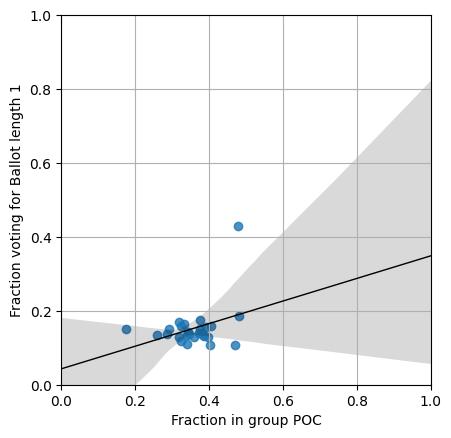

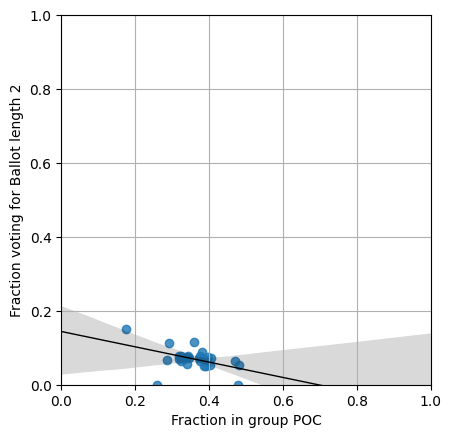

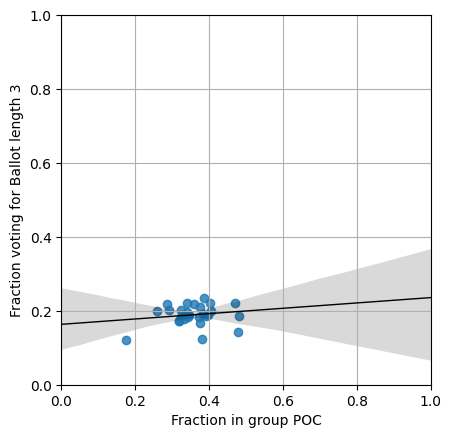

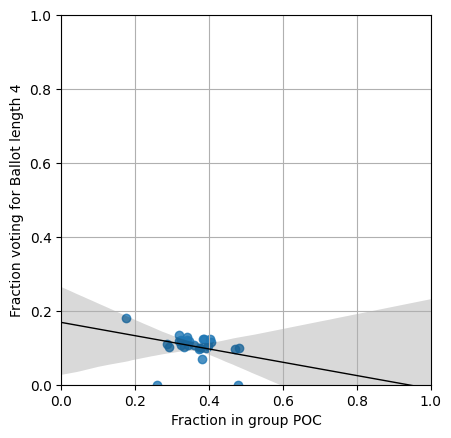

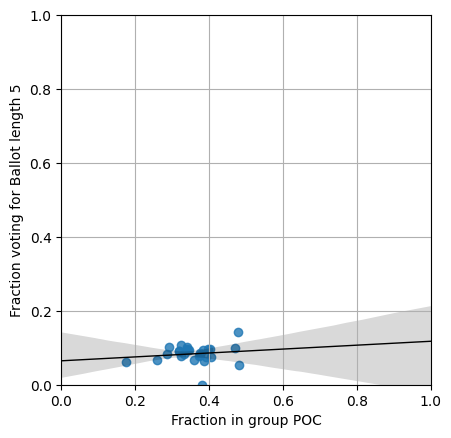

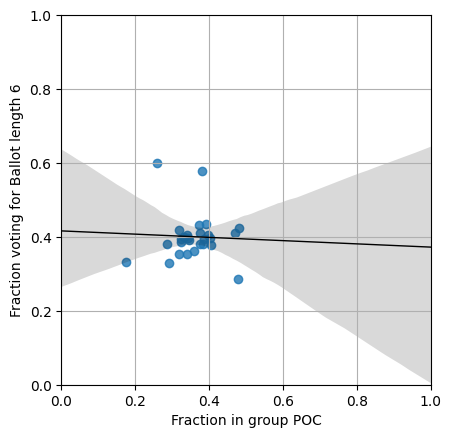

In [29]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Ballot length"
election_total_votes = "Ballot length total"


pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "AMIN": "AMINDVAP22 pct",
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(1,7):
    for demographic_group_name in demographic_groups:   
        candidate_name = election + " " + str(i)
        votes_fraction = np.array(D1_precincts_df[candidate_name + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting Goodman's ER - precincts weighted by population
        # Create a GoodmansER object
        goodmans_er = GoodmansER(is_weighted_regression=True)

        # Fit the model
        goodmans_er.fit(
            group_fraction,
            votes_fraction,
            precinct_votes,
            demographic_group_name=demographic_group_name,
            candidate_name=candidate_name
         )

        goodmans_er.plot(line_kws={"color":"black", "lw": 1})
        
        # Generate a simple report to summarize the results
        print(goodmans_er.summary())
    

### 2x2 EI:

Ballot length 1 , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

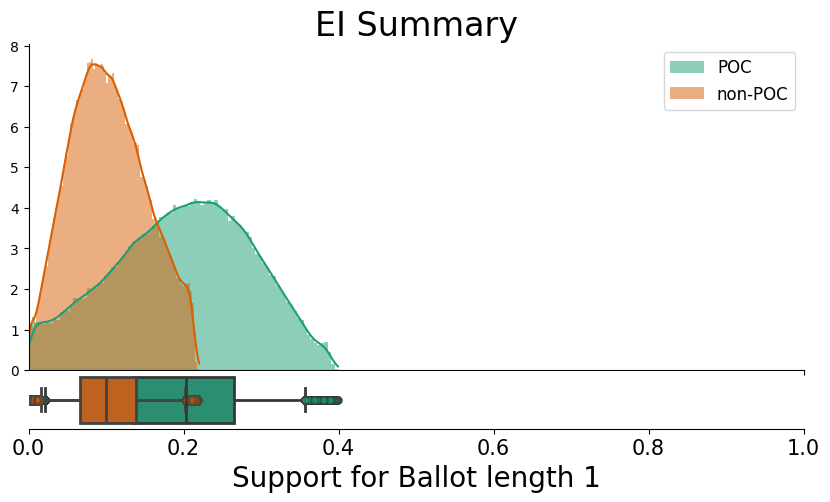

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Ballot length 1 is
        0.198
        The posterior mean for the district-level voting preference of
        non-POC for Ballot length 1 is
        0.103
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Ballot length 1 is
        [0.0210218  0.35608097]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Ballot length 1 is
        [0.01635726 0.20143887]
        
Ballot length 2 , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


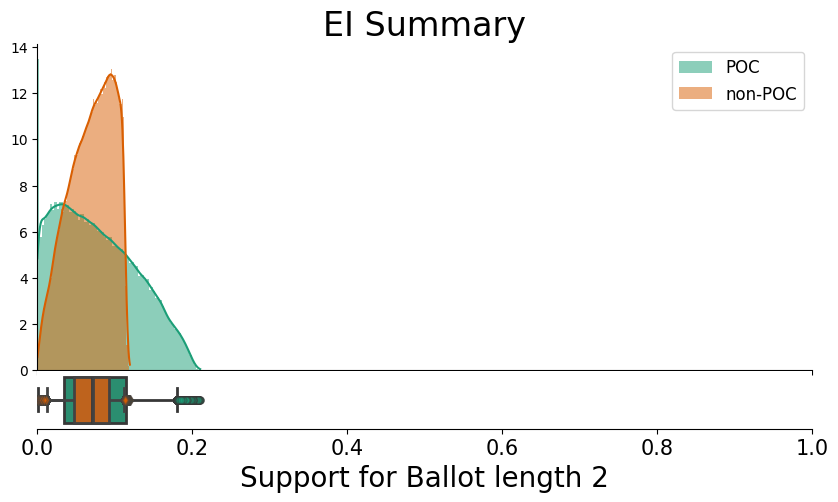

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Ballot length 2 is
        0.077
        The posterior mean for the district-level voting preference of
        non-POC for Ballot length 2 is
        0.069
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Ballot length 2 is
        [0.00100626 0.18009576]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Ballot length 2 is
        [0.01207577 0.11124536]
        
Ballot length 3 , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

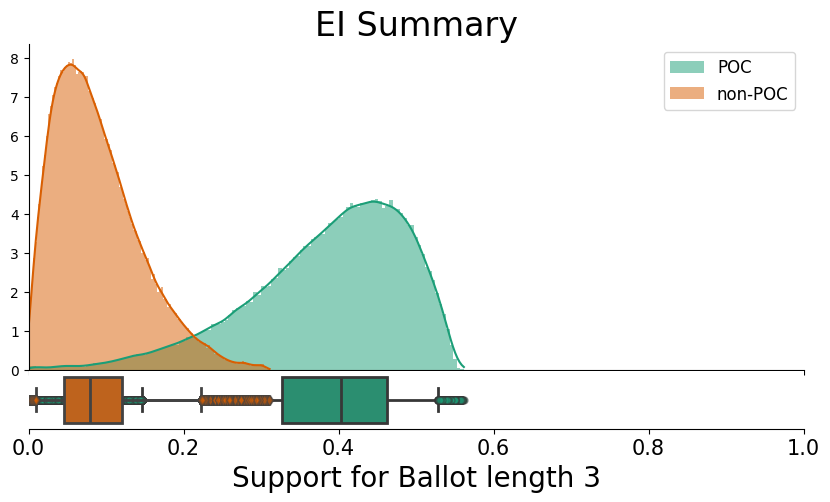

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Ballot length 3 is
        0.386
        The posterior mean for the district-level voting preference of
        non-POC for Ballot length 3 is
        0.089
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Ballot length 3 is
        [0.14648729 0.5288878 ]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Ballot length 3 is
        [0.01017128 0.22233751]
        
Ballot length 4 , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

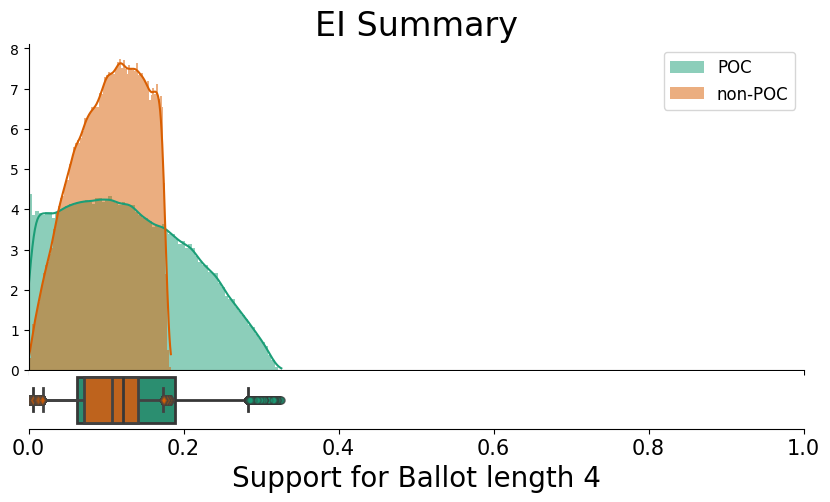

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Ballot length 4 is
        0.128
        The posterior mean for the district-level voting preference of
        non-POC for Ballot length 4 is
        0.105
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Ballot length 4 is
        [0.00596896 0.28345744]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Ballot length 4 is
        [0.01891563 0.17292375]
        
Ballot length 5 , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


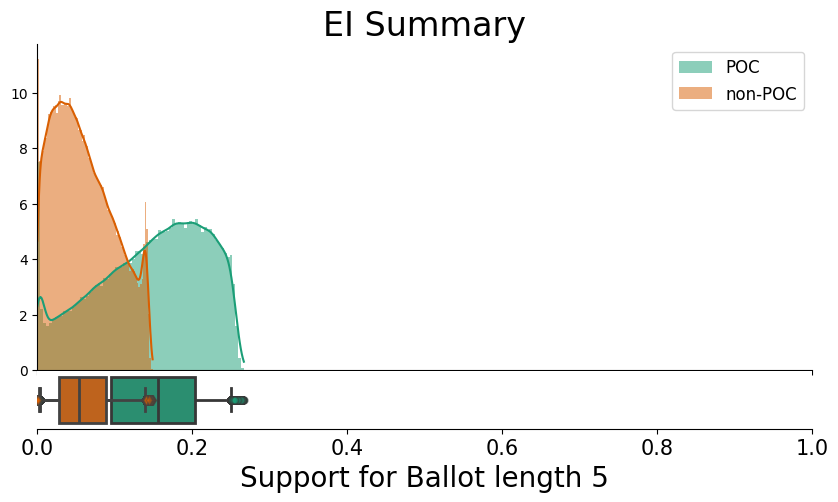

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Ballot length 5 is
        0.146
        The posterior mean for the district-level voting preference of
        non-POC for Ballot length 5 is
        0.060
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Ballot length 5 is
        [0.00286425 0.25024287]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Ballot length 5 is
        [0.00233098 0.13906227]
        
Ballot length 6 , POC


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

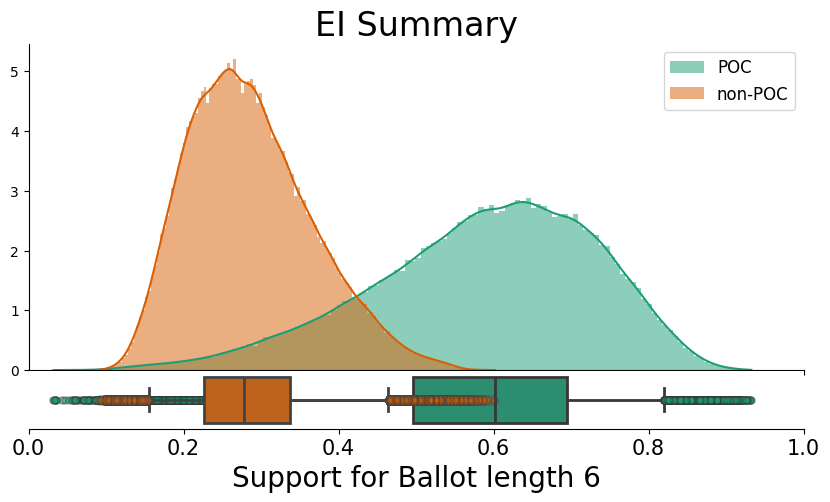

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        POC for Ballot length 6 is
        0.587
        The posterior mean for the district-level voting preference of
        non-POC for Ballot length 6 is
        0.286
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        POC for Ballot length 6 is
        [0.27001089 0.82047915]
        95% equal-tailed Bayesian credible interval for district-level voting preference of
        non-POC for Ballot length 6 is
        [0.15574489 0.4634133 ]
        


In [30]:
precinct_names = D1_precincts_df['Precinct']
demographic_groups = ["POC"]
election = "Ballot length"
election_total_votes = "Ballot length total"


pop_pct_dict = {
    "Hispanic" : "HDVAP22 pct", 
    "Asian" : "AAPIDVAP22 pct", 
    "Black" : "BDVAP22 pct", 
    "POC": "POCDVAP22 pct",
    "White" : "WDVAP22 pct"
}


for i in range(1,7):
    for demographic_group_name in demographic_groups:   
        candidate_name = election + " " + str(i)
        votes_fraction = np.array(D1_precincts_df[candidate_name + " pct"])
        precinct_votes = np.array(D1_precincts_df[election_total_votes])

        print(candidate_name, ',', demographic_group_name)
        group_fraction = np.array(D1_precincts_df[pop_pct_dict[demographic_group_name]])

        # Fitting a first 2 x 2 model

         # Create a TwobyTwoEI object
        ei_2by2 = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=50, pareto_shape=10)

        # Fit the model
        ei_2by2.fit(group_fraction,
                votes_fraction,
                precinct_votes,
                demographic_group_name=demographic_group_name,
                candidate_name=candidate_name,
                precinct_names=precinct_names,
                draws=50000, # optional
                tune=10000, # optional
                target_accept=.999# optional
        )

        ei_2by2.plot()
        plt.show()

        # Plot the rhat and ess statistics and plot trace to see what's going on with these!
        #az.rhat(ei_2by2.sim_trace)
        #az.ess(ei_2by2.sim_trace)
        #az.plot_trace(ei_2by2.sim_trace, compact=True)

        # Generate a simple report to summarize the results
        print(ei_2by2.summary())

### Support by race for Ballot length 6 looks REALLY different in 2x2 than in RxC.  I don't know how to interpret that.

### 2xC with POC combined:

Running ['POC', 'White'] x ['Ballot length 1', 'Ballot length 2', 'Ballot length 3', 'Ballot length 4', 'Ballot length 5', 'Ballot length 6'] EI
r = 2 rows (demographic groups)
c = 6 columns (candidates or voting outcomes)
number of precincts = 27


  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

  0%|          | 0/51500 [00:00<?, ?it/s]

/opt/miniconda3/envs/gerry2024/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:910: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,50000,27,2,5]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


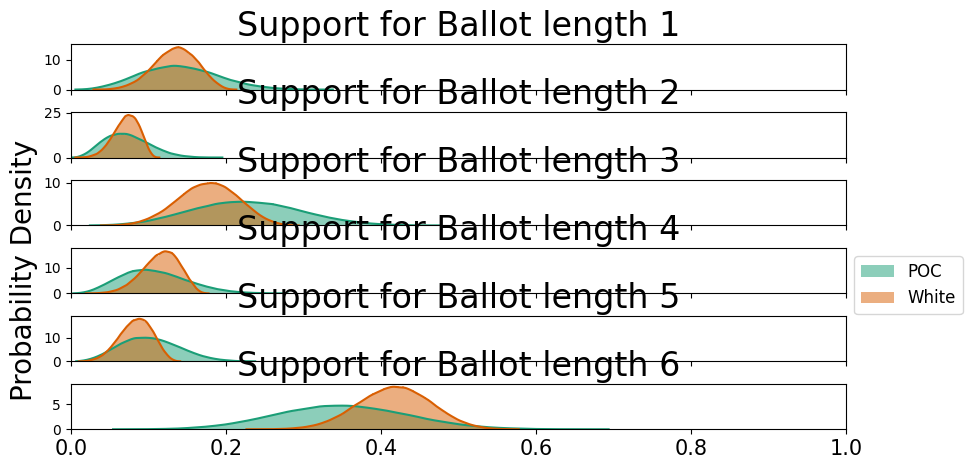


            Computed from the raw b_ samples by multiplying by group populations and then
            getting the proportion of the total pop
            (total pop=summed across all districts):
            The posterior mean for the district-level voting preference of
                POC for Ballot length 1 is
                0.140
                95% equal-tailed credible interval:  [0.05104094 0.24167369]
                The posterior mean for the district-level voting preference of
                POC for Ballot length 2 is
                0.072
                95% equal-tailed credible interval:  [0.02355318 0.1335781 ]
                The posterior mean for the district-level voting preference of
                POC for Ballot length 3 is
                0.227
                95% equal-tailed credible interval:  [0.09900084 0.36515631]
                The posterior mean for the district-level voting preference of
                POC for Ballot length 4 is
                0.107
 

In [31]:
precinct_names = D1_precincts_df['Precinct']
demographic_group_names = ["POC", "White"]
election = "Ballot length"
election_total_votes = "Ballot length total"

candidate_names = [election + " " + str(i) for i in range(1,7)]

votes_fractions = np.array(D1_precincts_df[[name + " pct" for name in candidate_names]]).T
precinct_votes = np.array(D1_precincts_df[election_total_votes])

group_fractions = np.array(D1_precincts_df[['POCDVAP22 pct', 'WDVAP22 pct']]).T

ei = RowByColumnEI(model_name='multinomial-dirichlet')
ei.fit(group_fractions, votes_fractions, precinct_votes, demographic_group_names, candidate_names, draws=50000, target_accept=.999)

ei.plot()
plt.show()
print(ei.summary())

#ei.precinct_level_plot(D1_candidates[i])